In [23]:
# ===== Cell 0: 環境設定（全セル共通で利用）=====

from __future__ import annotations

from typing import Any, Callable, Dict, Optional

import os
import numpy as np
import pandas as pd
import matplotlib           # 追加
import matplotlib.backends  # 追加（←これがポイント）
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# ------------------------
# 実験スイッチ（Notebook全体で共有）
# ------------------------
FMS_THRESHOLD: int = 1           # FMS >= 1 を陽性ラベルとみなす
EPOCH_LEN: int = 30               # 30 / 60 / 120 のいずれか
MODEL_BACKEND: str = "xgb"        # "xgb" / "rf" / "svm"
USE_MSSQ_FEATURE: bool = True    # True: MSSQ を Cell4/Cell5 の特徴に含める
USE_VIMSSQ_FEATURE: bool = False  # True: VIMSSQ を含める
SEED_BASE: int = 20251101
TOP_SUBSET_K: int = 10           # subset探索で使う上位特徴数

if EPOCH_LEN not in (30, 60, 120):
    raise ValueError("EPOCH_LEN は 30/60/120 から選択してください。")

# ---------------- 設定（等間隔グリッド＋近傍再探索） ----------------
COARSE_STEPS = 101      # 0.0〜1.0 を等間隔
FINE_STEPS   = 101      # 近傍再探索の細かさ
FINE_MARGIN  = 0.01      # 近傍幅（±0.01）
VERBOSE      = True

# ------------------------
# ファイル入出力ルート
# ------------------------
BASE_INPUT_DIR = r"C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果"
BASE_ANALYSIS_DIR = os.path.join(BASE_INPUT_DIR, "ANALYSIS")
OUT_DIR = os.path.join(BASE_ANALYSIS_DIR, "機械学習(SHAP_REF法)", f"TEST_閾値FMS{FMS_THRESHOLD}_k={TOP_SUBSET_K}")
os.makedirs(OUT_DIR, exist_ok=True)

def outpath(filename: str) -> str:
    return os.path.join(OUT_DIR, filename)

print(f"[OUT_DIR] {OUT_DIR}  |  EPOCH_LEN={EPOCH_LEN}s")

# ------------------------
# 対象被験者・時間窓
# ------------------------
SUBJECT_IDS = [
    "10061","10063","10064",
    "10071","10072","10073","10074",
    "10081","10082","10083",
    "10091","10092","10093","10094",
    "10101","10102","10103",
]

BASELINE_EPOCH = 1770               # ベースライン行（必須）
ML_START, ML_END = 1800, 2400       # 学習に使う epoch_start 範囲 [start, end)

# ------------------------
# 描画スタイル
# ------------------------
plt.rcParams.update({
    "figure.dpi": 120, "savefig.dpi": 300,
    "font.size": 20, "axes.titlesize": 26, "axes.labelsize": 22,
    "xtick.labelsize": 20, "ytick.labelsize": 20, "legend.fontsize": 20,
})

# ------------------------
# FMS二値化ヘルパ
# ------------------------
def binarize_fms(series: pd.Series, threshold: Optional[int] = None) -> pd.Series:
    th = FMS_THRESHOLD if threshold is None else int(threshold)
    return (series >= th).astype(int)

# ------------------------
# モデルレジストリ
# ------------------------
ModelBuilder = Callable[..., Any]
MODEL_REGISTRY: Dict[str, Dict[str, Any]] = {}

def register_backend(name: str, params: Dict[str, Any], builder: ModelBuilder) -> None:
    MODEL_REGISTRY[name] = {"params": params, "builder": builder}

def _build_xgb(params: Dict[str, Any], *, scale_pos_weight: Optional[float] = None):
    cfg = params.copy()
    if scale_pos_weight is not None:
        cfg["scale_pos_weight"] = float(scale_pos_weight)
    return xgb.XGBClassifier(**cfg)

def _build_rf(params: Dict[str, Any], **_):
    return RandomForestClassifier(**params)

def _build_svm(params: Dict[str, Any], **_):
    return SVC(**params)

XGB_PARAMS: Dict[str, Any] = dict(
    n_estimators=100,
    eval_metric="logloss",
    subsample=1.0,
    colsample_bytree=1.0,
    n_jobs=1,
    tree_method="hist",
    device="cpu",
    seed=0,
    random_state=0,
)

RF_PARAMS: Dict[str, Any] = dict(
    n_estimators=100,      # 論文：決定木100本
    max_features=1,        # 論文：max feature of one

    # 以下は論文に記載がないので，ほぼデフォルト＋再現性用
    bootstrap=True,        # scikit-learn のデフォルト
    random_state=SEED_BASE,
    n_jobs=1,
)


SVM_PARAMS: Dict[str, Any] = dict(
    C=1.0,
    kernel="rbf",
    gamma="scale",
    probability=True,
    class_weight="balanced",
    random_state=SEED_BASE,
)

register_backend("xgb", XGB_PARAMS, _build_xgb)
register_backend("rf",  RF_PARAMS,  _build_rf)
register_backend("svm", SVM_PARAMS, _build_svm)

def set_model_backend(name: str) -> None:
    name = name.lower()
    if name not in MODEL_REGISTRY:
        raise KeyError(f"[ERROR] backend '{name}' は未登録: {list(MODEL_REGISTRY.keys())}")
    global MODEL_BACKEND
    MODEL_BACKEND = name

def build_estimator(
    backend: Optional[str] = None,
    *,
    scale_pos_weight: Optional[float] = None,
    overrides: Optional[Dict[str, Any]] = None,
):
    name = (backend or MODEL_BACKEND).lower()
    if name not in MODEL_REGISTRY:
        raise KeyError(f"[ERROR] backend '{name}' は未登録。")
    base = MODEL_REGISTRY[name]["params"].copy()
    if overrides:
        base.update(overrides)
    builder = MODEL_REGISTRY[name]["builder"]
    return builder(base, scale_pos_weight=scale_pos_weight)

def fit_estimator(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    *,
    backend: Optional[str] = None,
    scale_pos_weight: Optional[float] = None,
    overrides: Optional[Dict[str, Any]] = None,
):
    X_train = X_train.astype(np.float32, copy=False)
    y_train = y_train.astype(np.int32, copy=False)
    model = build_estimator(
        backend=backend, scale_pos_weight=scale_pos_weight, overrides=overrides
    )
    model.fit(X_train, y_train)
    return model

def predict_positive_score(model, X: pd.DataFrame) -> np.ndarray:
    X = X.astype(np.float32, copy=False)
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return np.asarray(model.decision_function(X), dtype=float)
    return model.predict(X).astype(float)

MODEL_ID = MODEL_BACKEND.upper()
print(f"[INFO] MODEL_BACKEND={MODEL_ID} / SEED={SEED_BASE} / backends={list(MODEL_REGISTRY.keys())}")


[OUT_DIR] C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10  |  EPOCH_LEN=30s
[INFO] MODEL_BACKEND=XGB / SEED=20251101 / backends=['xgb', 'rf', 'svm']


In [24]:
# ===== Cell 1: データ準備（CSV読込 → EPOCH合成 → SUBJECT_META → 行列出力）=====

import pandas as pd
import numpy as np
import os

# --------------------------------------------
# ① 30秒EPOCH CSVの読み込み・検証
# --------------------------------------------
def subject_csv_path(sid: str) -> str:
    path = os.path.join(BASE_INPUT_DIR, sid, "EPOCH", f"{sid}_epoch.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"[Cell1] CSV missing for subject {sid}: {path}")
    return path

dfs = []
for sid in SUBJECT_IDS:
    df = pd.read_csv(subject_csv_path(sid))
    if df.shape[1] < 4:
        raise ValueError(f"[Cell1] {sid}: 列数が不足（>=4 必須）")
    df = df.copy()
    # 4列目以降の列名を文字列化（数値列名対策）
    df.columns = list(df.columns[:3]) + [str(c) for c in df.columns[3:]]
    c1, c2, c3 = df.columns[:3]
    df = df.rename(columns={c1: "epoch_start", c2: "epoch_end", c3: "FMS"})
    df["epoch_start"] = pd.to_numeric(df["epoch_start"], errors="coerce").astype("Int64")
    df["epoch_end"]   = pd.to_numeric(df["epoch_end"],   errors="coerce").astype("Int64")
    df["FMS"]         = pd.to_numeric(df["FMS"],         errors="coerce").astype("Int64")
    if df[["epoch_start","epoch_end","FMS"]].isna().any().any():
        raise ValueError(f"[Cell1] {sid}: epoch_start/epoch_end/FMS に NaN")
    df.insert(0, "subject_id", sid)
    dfs.append(df)

combined_raw = pd.concat(dfs, ignore_index=True)

# 除外する特徴量（周波数領域など）
exclude_feats = {"HF_power", "LF_power", "LF_HF_ratio"}
feature_cols_all = [
    c for c in combined_raw.columns
    if c not in {"subject_id","epoch_start","epoch_end","FMS"} and c not in exclude_feats
]
if not feature_cols_all:
    raise RuntimeError("[Cell1] 特徴量列が0です。列名や除外設定を確認してください。")

print(f"[Cell1] Loaded subjects={len(SUBJECT_IDS)}, rows={len(combined_raw)}, "
      f"features(after drop)={len(feature_cols_all)}")

# ★ デバッグ(1): 生理特徴量のリストをプリント
print("[Cell1] Physiological feature columns (feature_cols_all):")
for col in feature_cols_all:
    print("  -", col)

# --------------------------------------------
# ② EPOCH_LEN 秒への合成 + baseline差分 + ラベル生成
# --------------------------------------------
if (ML_END - ML_START) % EPOCH_LEN != 0:
    raise ValueError(f"[Cell1] ML window {ML_END-ML_START} が EPOCH_LEN={EPOCH_LEN} で割り切れません。")

rows_per_bin = EPOCH_LEN // 30
df_out_list = []

# ★ デバッグ用ディレクトリ
DEBUG_DIR = os.path.join(OUT_DIR, "Cell1_デバッグ")
os.makedirs(DEBUG_DIR, exist_ok=True)

for sid, sdf in combined_raw.groupby("subject_id", sort=False):
    # baseline 行（1770）の行を1行だけ取る
    base_row = sdf.loc[sdf["epoch_start"] == BASELINE_EPOCH]
    if len(base_row) != 1:
        raise ValueError(f"[Cell1] {sid}: baseline epoch_start=={BASELINE_EPOCH} が見つからない")
    base_vals = base_row[feature_cols_all].astype(float).iloc[0]
    if base_vals.isna().any():
        raise ValueError(f"[Cell1] {sid}: baselineにNaN -> {base_vals.index[base_vals.isna()].tolist()}")

    # 学習に使う時間窓だけ抽出
    sdf_ml = sdf[(sdf["epoch_start"] >= ML_START) & (sdf["epoch_start"] < ML_END)].copy()
    if sdf_ml.empty:
        raise ValueError(f"[Cell1] {sid}: ML window [{ML_START},{ML_END}) が空です。")

    # 30秒epochを EPOCH_LEN 秒にまとめるためのbin
    sdf_ml["bin_start"] = ML_START + ((sdf_ml["epoch_start"] - ML_START) // EPOCH_LEN) * EPOCH_LEN
    sdf_ml["bin_end"]   = sdf_ml["bin_start"] + EPOCH_LEN

    # 行数が揃っている bin のみ採用
    bin_counts = sdf_ml.groupby(["bin_start","bin_end"]).size()
    complete_bins = bin_counts[bin_counts == rows_per_bin].index
    sdf_ml = sdf_ml.set_index(["bin_start","bin_end"]).loc[complete_bins].reset_index()
    if sdf_ml.empty:
        raise ValueError(f"[Cell1] {sid}: EPOCH_LEN={EPOCH_LEN} で完全なbinが無い")

    # 各 bin で平均を取る（FMS も平均）
    agg_dict = {c: "mean" for c in feature_cols_all}
    agg_dict["FMS"] = "mean"
    g = sdf_ml.groupby(["subject_id","bin_start","bin_end"], as_index=False).agg(agg_dict)

    # baseline 差分（生理特徴量のみ）
    g_features = g[feature_cols_all].astype(float) - base_vals.values
    if g_features.isna().any().any():
        bad = g_features.columns[g_features.isna().any()].tolist()
        raise ValueError(f"[Cell1] {sid}: baseline差分後にNaN -> {bad}")

    # 出力用に整形
    g_out = pd.concat([g[["subject_id","bin_start","bin_end","FMS"]], g_features], axis=1)
    g_out = g_out.rename(columns={"bin_start":"epoch_start","bin_end":"epoch_end"})
    g_out["label"] = binarize_fms(g_out["FMS"])
    g_out = g_out[["subject_id","epoch_start","epoch_end","FMS","label"] + feature_cols_all]

    # ★ デバッグ(2): この被験者のベースライン差分後データをCSVに保存
    debug_path = os.path.join(DEBUG_DIR, f"Cell1_debug_{sid}_E{EPOCH_LEN}s.csv")
    g_out.to_csv(debug_path, index=False, encoding="utf-8-sig")
    print(f"[Cell1-DEBUG] Saved baseline-diff data for subject {sid} -> {debug_path}")

    df_out_list.append(g_out)

df_ml_epoch = pd.concat(df_out_list, ignore_index=True)

# --------------------------------------------
# ③ SUBJECT_META & MSSQ group（被験者属性読み込み）
# --------------------------------------------
CANDIDATE_SCORE_PATHS = [
    "/mnt/data/summary_scores.xlsx",
    os.path.join(BASE_ANALYSIS_DIR, "summary_scores.xlsx"),
    os.path.join(BASE_ANALYSIS_DIR, "機械学習", "summary_scores.xlsx"),
    os.path.join(BASE_INPUT_DIR, "summary_scores.xlsx"),
]
score_path = next((p for p in CANDIDATE_SCORE_PATHS if os.path.exists(p)), None)
if score_path is None:
    raise FileNotFoundError("[Cell1] summary_scores.xlsx が見つかりません。")
meta_raw = pd.read_excel(score_path, sheet_name="Summary")

required = ["ID", "MSSQ", "VIMSSQ"]
missing = [c for c in required if c not in meta_raw.columns]
if missing:
    raise ValueError(f"[Cell1] summary_scores.xlsx に必須列がありません -> {missing}")

meta = meta_raw[required].copy()
meta["ID"] = (
    meta["ID"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
)
for c in ["MSSQ", "VIMSSQ"]:
    meta[c] = pd.to_numeric(meta[c], errors="raise")

sid_set = set(map(str, SUBJECT_IDS))
meta = meta[meta["ID"].isin(sid_set)].copy()
if meta["ID"].duplicated().any():
    raise ValueError(f"[Cell1] ID 重複 -> {meta.loc[meta['ID'].duplicated(), 'ID'].tolist()}")

MSSQ_THRESHOLD_FIXED = 12.0
meta["MSSQ_group"] = np.where(meta["MSSQ"] >= MSSQ_THRESHOLD_FIXED, "High", "Low")
SUBJECT_META = (
    meta.rename(columns={"ID": "subject_id"})
        .set_index("subject_id")[["MSSQ", "VIMSSQ", "MSSQ_group"]]
        .copy()
)
SUBJECT_META.to_csv(outpath("subject_meta.csv"), encoding="utf-8-sig")
print(f"[Cell1] SUBJECT_META saved -> {outpath('subject_meta.csv')} (source='{score_path}')")

# ---- ここから：MSSQ / VIMSSQ をフラグに応じて特徴量に追加 ----
trait_cols_to_use = []
if USE_MSSQ_FEATURE:
    trait_cols_to_use.append("MSSQ")
if USE_VIMSSQ_FEATURE:
    trait_cols_to_use.append("VIMSSQ")

if trait_cols_to_use:
    # 必要な列だけを df_ml_epoch にマージ
    merge_cols = ["subject_id"] + trait_cols_to_use
    df_ml_epoch = df_ml_epoch.merge(
        SUBJECT_META.reset_index()[merge_cols],
        on="subject_id",
        how="left",
    )

    if df_ml_epoch[trait_cols_to_use].isna().any().any():
        bad_sids = df_ml_epoch.loc[
            df_ml_epoch[trait_cols_to_use].isna().any(axis=1), "subject_id"
        ].unique().tolist()
        raise ValueError(f"[Cell1] MSSQ/VIMSSQ が欠損の subject_id があります -> {bad_sids}")

    print("[Cell1] df_ml_epoch with trait features:")
    print(df_ml_epoch[["subject_id"] + trait_cols_to_use].drop_duplicates().head())
else:
    print("[Cell1] Trait features (MSSQ/VIMSSQ) are disabled by flags.")

# 生理特徴量 + （オプションの）MSSQ/VIMSSQ をまとめた最終的な特徴量リスト
feature_cols_full = feature_cols_all + trait_cols_to_use

# デバッグ: 最終的な特徴量リストをプリント
print(f"[Cell1] Final feature columns (n={len(feature_cols_full)}):")
for col in feature_cols_full:
    print("  -", col)

# --------------------------------------------
# ④ 学習行列＆行列保存
# --------------------------------------------
fname_raw = f"ML_DATA_DELTA_{EPOCH_LEN}S_RAW.CSV"
df_ml_epoch.to_csv(outpath(fname_raw), index=False, encoding="utf-8-sig")

X_all = df_ml_epoch[feature_cols_full].copy().astype(float)
y_all = df_ml_epoch["label"].copy().astype(int)
groups = df_ml_epoch["subject_id"].copy()

X_all.to_csv(outpath(f"X_RAW_ALL_{EPOCH_LEN}S.CSV"), index=False, encoding="utf-8-sig")
X_all.to_csv(outpath(f"X_SCALED_ALL_{EPOCH_LEN}S.CSV"), index=False, encoding="utf-8-sig")  # 木系でスケーリング不要
pd.DataFrame({"subject_id": groups, "label": y_all, "FMS_mean": df_ml_epoch["FMS"]}).to_csv(
    outpath(f"Y_AND_GROUPS_{EPOCH_LEN}S.CSV"), index=False, encoding="utf-8-sig"
)

print(f"[Cell1] Saved -> {outpath(fname_raw)} / X_RAW_ALL / X_SCALED_ALL / Y_AND_GROUPS")
print(f"[Cell1] Matrices ready: X_all={X_all.shape}, y_all={y_all.shape}, SUBJECT_META={SUBJECT_META.shape}")
print(f"[Cell1] n_features(physio)={len(feature_cols_all)}, "
      f"+ traits({len(trait_cols_to_use)}) -> {len(feature_cols_full)}")


[Cell1] Loaded subjects=17, rows=357, features(after drop)=45
[Cell1] Physiological feature columns (feature_cols_all):
  - CSI
  - CVI
  - AB_max_mean
  - AB_max_std
  - AB_max_slope
  - C_max_mean
  - C_max_std
  - C_max_slope
  - ABC_max_mean
  - ABC_max_std
  - ABC_max_slope
  - AB_mean_mean
  - AB_mean_std
  - AB_mean_slope
  - C_mean_mean
  - C_mean_std
  - C_mean_slope
  - ABC_mean_mean
  - ABC_mean_std
  - ABC_mean_slope
  - AB_maxdiff_mean
  - AB_maxdiff_std
  - AB_maxdiff_slope
  - AB_meandiff_mean
  - AB_meandiff_std
  - AB_meandiff_slope
  - HeartRate
  - pNN50
  - RMSSD
  - RR_mean
  - SD1
  - SD2
  - SDSD
  - watch_Sweat_Rate_mean
  - watch_Sweat_Rate_std
  - watch_Sweat_Rate_slope
  - watch_Heart_Rate_mean
  - watch_Heart_Rate_std
  - watch_Heart_Rate_slope
  - watch_Skin_Temp_mean
  - watch_Skin_Temp_std
  - watch_Skin_Temp_slope
  - Sweat_mean
  - Sweat_std
  - Sweat_slope
[Cell1-DEBUG] Saved baseline-diff data for subject 10061 -> C:\Users\taiki\OneDrive - Science Tok

In [25]:
# ===== Cell 2: モデリング共通ヘルパ（fit / SHAP / 評価）=====

from typing import Dict, Optional, Tuple

import numpy as np
import pandas as pd
import shap
from sklearn.metrics import roc_auc_score, accuracy_score


# --------------------------------------------
# 学習ラッパー（Cell0のレジストリAPIを利用）
# --------------------------------------------
def fit_classifier(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    *,
    backend: Optional[str] = None,
    scale_pos_weight: Optional[float] = None,
    overrides: Optional[Dict[str, Any]] = None,
):
    """
    Cell0 の fit_estimator を直接包む薄いラッパ。
    - SHAP/評価セルから backend を差し替えたい場合のみ backend / overrides を指定する。
    """
    if "fit_estimator" not in globals():
        raise RuntimeError("[Cell2] fit_estimator が未定義です。Cell0 を先に実行してください。")
    X_train = X_train.astype(np.float32, copy=False)
    y_train = y_train.astype(np.int32, copy=False)
    return fit_estimator(
        X_train,
        y_train,
        backend=backend,
        scale_pos_weight=scale_pos_weight,
        overrides=overrides,
    )


# --------------------------------------------
# TreeSHAP ベースの特徴重要度算出
# --------------------------------------------
def compute_train_shap_abs_mean(model, X_ref: pd.DataFrame) -> pd.Series:
    """
    学習データ X_ref 上での平均絶対SHAP値（降順）。
    - XGB/RF 等の木モデルを想定（TreeSHAP）。
    - SVM など非対応モデルでは ValueError を送出する。
    """
    X_ref = X_ref.astype(np.float32, copy=False)

    # 背景データ（最大128行）
    bg_n = min(128, len(X_ref))
    X_bg = X_ref.sample(n=bg_n, random_state=SEED_BASE) if bg_n >= 2 else X_ref

    try:
        explainer = shap.TreeExplainer(
            model,
            data=X_bg,
            model_output="probability",
            feature_perturbation="interventional",
        )
        sv_any = explainer.shap_values(X_ref)
    except Exception:
        # probability指定が非対応な場合に raw へフォールバック
        explainer = shap.TreeExplainer(
            model,
            model_output="raw",
            feature_perturbation="tree_path_dependent",
        )
        sv_any = explainer.shap_values(X_ref)

    # shap_values の戻り値形状を統一（2D: n_samples × n_features）
    classes = getattr(model, "classes_", None)
    pos_idx = int(np.where(classes == 1)[0][0]) if classes is not None and 1 in list(classes) else -1

    if isinstance(sv_any, list):
        sv = sv_any[pos_idx]
    else:
        sv = getattr(sv_any, "values", sv_any)
        sv = np.asarray(sv)
        if sv.ndim == 3:
            sv = sv[..., pos_idx]
        elif sv.ndim == 1:
            sv = sv.reshape(-1, 1)

    if sv.shape[1] != X_ref.shape[1]:
        raise RuntimeError(
            f"[Cell2] SHAP shape mismatch: sv.shape={sv.shape}, X_ref.shape={X_ref.shape}"
        )

    abs_mean = np.mean(np.abs(sv), axis=0)
    return pd.Series(abs_mean, index=X_ref.columns, name="mean_abs").sort_values(ascending=False)


# --------------------------------------------
# 評価ユーティリティ
# --------------------------------------------
def _is_probability_like(scores: np.ndarray) -> bool:
    return np.isfinite(scores).all() and 0.0 <= scores.min() and scores.max() <= 1.0


def evaluate_fold(model, X_test: pd.DataFrame, y_test: pd.Series) -> Dict[str, float]:
    """
    - ROC AUC: 2クラス時のみ。
    - Accuracy: 確率なら 0.5、スコアなら 0.0 を閾値とする（詳細な最適化は別セル）。
    """
    X_test = X_test.astype(np.float32, copy=False)
    scores = predict_positive_score(model, X_test)

    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, scores)
    else:
        roc_auc = float("nan")

    thr = 0.5 if _is_probability_like(scores) else 0.0
    pred = (scores >= thr).astype(int)
    acc = accuracy_score(y_test.astype(int), pred)

    return {"roc_auc": float(roc_auc), "accuracy": float(acc)}


print("[Cell2] Modeling helpers ready (fit_classifier / compute_train_shap_abs_mean / evaluate_fold)")


[Cell2] Modeling helpers ready (fit_classifier / compute_train_shap_abs_mean / evaluate_fold)


# ===== Cell 3A-pre: 高相関特徴の事前除去 =====

RFE の前に、全特徴の相関をチェックして |r| が閾値以上のペアを間引きます。
列順（X_all の元々の並び）を優先し、残す列と除外した列を JSON に保存します。


In [26]:
# ===== Cell 3A-pre: 高相関特徴の事前除去 =====
import json
import numpy as np
import pandas as pd

required = ["X_all", "outpath"]
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError(f"[Cell3A-pre] 未定義の変数/関数があります: {missing}")

CORR_THRESHOLD = 0.70
MIN_VARIANCE = 1e-8
FEATURE_LIST_PATH = outpath("FEATURES_AFTER_CORR.json")

X_num = X_all.select_dtypes(include=[np.number]).copy()
if X_num.empty:
    raise RuntimeError("[Cell3A-pre] 数値列がありません。")

var = X_num.var(axis=0, ddof=1).fillna(0.0)
valid_cols = var[var > MIN_VARIANCE].index.tolist()
if not valid_cols:
    raise RuntimeError("[Cell3A-pre] 分散がほぼゼロのため使用可能な列がありません。")

# 優先順は X_all の列順を維持（先に出てきた方を優先して残す）
priority = [c for c in X_all.columns if c in valid_cols]
X_use = X_num[priority]

corr = X_use.corr(method="pearson").abs()
keep = []
dropped = []

for col in priority:
    conflict = None
    for kept in keep:
        if corr.loc[col, kept] >= CORR_THRESHOLD:
            conflict = kept
            break
    if conflict is None:
        # まだどの kept とも高相関でない → 代表として残す
        keep.append(col)
    else:
        # すでに keep に入っている代表 (conflict) を残し、後から出てきた col を除去
        dropped.append({
            "feature": col,           # ← 今回「除去した側」
            "representative": conflict,  # ← 残した側（代表）
            "abs_corr": float(corr.loc[col, conflict]),
        })

payload = {
    "keep": keep,
    "dropped": dropped,
    "threshold": CORR_THRESHOLD,
    "total_columns": len(priority),
}
with open(FEATURE_LIST_PATH, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

print(f"[Cell3A-pre] keep={len(keep)} / total={len(priority)}, dropped={len(dropped)}")
print(f"[Cell3A-pre] JSON -> {FEATURE_LIST_PATH}")

# ---- ログ出力：どっちを KEEP, どっちを DROP したか ----
if dropped:
    print(f"[Cell3A-pre] |r| >= {CORR_THRESHOLD:.2f} のペア（後から出てきた方を DROP）：")
    for d in dropped:
        print(
            f"  [KEEP] {d['representative']}  "
            f"[DROP] {d['feature']}  "
            f"(abs_corr={d['abs_corr']:.3f})"
        )
else:
    print("[Cell3A-pre] 高相関による除去はありませんでした。")


[Cell3A-pre] keep=23 / total=45, dropped=22
[Cell3A-pre] JSON -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\FEATURES_AFTER_CORR.json
[Cell3A-pre] |r| >= 0.70 のペア（後から出てきた方を DROP）：
  [KEEP] AB_max_mean  [DROP] C_max_mean  (abs_corr=0.709)
  [KEEP] AB_max_mean  [DROP] ABC_max_mean  (abs_corr=0.964)
  [KEEP] AB_max_std  [DROP] ABC_max_std  (abs_corr=0.830)
  [KEEP] AB_max_slope  [DROP] ABC_max_slope  (abs_corr=0.913)
  [KEEP] AB_max_mean  [DROP] AB_mean_mean  (abs_corr=0.939)
  [KEEP] AB_max_std  [DROP] AB_mean_std  (abs_corr=0.903)
  [KEEP] AB_max_slope  [DROP] AB_mean_slope  (abs_corr=0.908)
  [KEEP] AB_max_mean  [DROP] C_mean_mean  (abs_corr=0.706)
  [KEEP] C_max_std  [DROP] C_mean_std  (abs_corr=0.797)
  [KEEP] C_max_slope  [DROP] C_mean_slope  (abs_corr=0.850)
  [KEEP] AB_max_mean  [DROP] ABC_mean_mean  (abs_corr=0.914)
  [KEEP] AB_max_std  [DROP] ABC_mean_std  (abs_corr=0.810)
  [KEEP] AB_max_slope  [DROP] ABC_mean_slope  (abs_co

In [27]:
# ===== Cell 3A: SHAPベース順位付け（LOSO, TreeSHAP） =====
from sklearn.model_selection import LeaveOneGroupOut
import json
import os

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.backends
import matplotlib.pyplot as plt

required = [
    "X_all", "y_all", "groups",
    "fit_classifier", "evaluate_fold",
    "outpath", "compute_train_shap_abs_mean"
]
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError(f"[Cell3A-SHAP-RANK] 未定義の変数/関数があります: {missing}")

# RFE_BACKEND に相当（TreeSHAP 対応の木モデル）
SHAP_BACKEND = "xgb"

RFE_STEP = 1          # 互換性のため残すが未使用
RFE_MIN_FEATURES = 1  # 互換性のため残すが未使用
FEATURE_LIST_PATH = outpath("FEATURES_AFTER_CORR.json")

# --- 特徴量プールの決定（相関事前除去の結果があれば利用） ---
if os.path.exists(FEATURE_LIST_PATH):
    with open(FEATURE_LIST_PATH, "r", encoding="utf-8") as f:
        keep_payload = json.load(f)
    feature_pool = [c for c in keep_payload.get("keep", []) if c in X_all.columns]
    print(f"[Cell3A-SHAP-RANK] correlation-pruned features loaded ({len(feature_pool)} cols)")
else:
    feature_pool = list(X_all.columns)
    print("[Cell3A-SHAP-RANK] correlation-pruned list not found. Using all columns.")

if not feature_pool:
    raise RuntimeError("[Cell3A-SHAP-RANK] feature_pool が空です。Cell3A-pre の結果を確認してください。")

X_source = X_all[feature_pool].copy()

logo = LeaveOneGroupOut()
ranking_frames = []
metrics_rows = []

# --- LOSO ループ ---
for fold_id, (tr_idx, te_idx) in enumerate(logo.split(X_source, y_all, groups), start=1):
    X_tr = X_source.iloc[tr_idx].astype(np.float32)
    y_tr = y_all.iloc[tr_idx].astype(int)
    X_te = X_source.iloc[te_idx].astype(np.float32)
    y_te = y_all.iloc[te_idx].astype(int)

    if len(np.unique(y_tr)) < 2:
        raise RuntimeError(f"[Cell3A-SHAP-RANK] fold{fold_id}: 学習側が単一クラスです。")

    # --- 木モデルで学習（TreeSHAP 対応） ---
    model = fit_classifier(X_tr, y_tr, backend=SHAP_BACKEND)

    # --- TreeSHAP による mean(|SHAP|) を学習データで計算 ---
    shap_mean = compute_train_shap_abs_mean(model, X_tr)  # index: feature, values: mean_abs（降順ソート済み）

    # 元の列順で揃えておく（fold 間でインデックス整合のため）
    shap_mean = shap_mean.reindex(X_tr.columns)

    # --- Fold 内で 1,2,3,... の順位化（大きいほど重要 → rank=1 が最重要） ---
    ranks = shap_mean.rank(ascending=False, method="min").astype(int)
    ranks.name = f"fold{fold_id}"
    ranking_frames.append(ranks)

    # --- Fold ごとの性能評価 ---
    metrics = evaluate_fold(model, X_te, y_te)
    metrics.update({
        "fold_id": fold_id,
        "test_subject": groups.iloc[te_idx].iloc[0],
    })
    metrics_rows.append(metrics)

    preview = shap_mean.sort_values(ascending=False).head(5).index.tolist()
    print(f"[Cell3A-SHAP-RANK] fold{fold_id}: ranked {X_tr.shape[1]} features (top5={preview})")

# --- fold 間の順位集約 ---
rfe_rank = pd.concat(ranking_frames, axis=1)  # index: feature, columns: fold1, fold2, ...

# 平均順位・中央値順位（小さいほど重要）
rfe_rank["rank_mean"] = rfe_rank.mean(axis=1)
rfe_rank["rank_median"] = rfe_rank.median(axis=1)

# 平均順位が小さい順にソート
rfe_rank = rfe_rank.sort_values("rank_mean")

rank_path = outpath("SHAP_FEATURE_RANKING.CSV")
rfe_rank.to_csv(rank_path, encoding="utf-8-sig")
rfe_rank.to_csv(outpath("SHAP_FEATURE_RANKING_LABELED.CSV"), encoding="utf-8-sig")
pd.DataFrame(metrics_rows).to_csv(outpath("LOSO_METRICS.CSV"), index=False, encoding="utf-8-sig")

print(f"[Cell3A-SHAP-RANK] Saved ranking -> {rank_path}")

# --- 可視化（全特徴）---
plt.figure(figsize=(10, max(5, len(rfe_rank)//3)))
plt.barh(rfe_rank.index[::-1], rfe_rank["rank_mean"][::-1])
plt.xlabel("Average rank (lower=better)")
plt.ylabel("Feature")
plt.title("SHAP-based Feature Ranking (All)")
plt.tight_layout()
plt.savefig(outpath("SHAP_RANKING_ALL.PNG"), dpi=300)
plt.close()

# --- 上位 TOP_K のみ ---
TOP_K = 8
topk = rfe_rank.head(TOP_K).iloc[::-1]

plt.figure(figsize=(12, 7))
ax = plt.gca()
ax.barh(topk.index, topk["rank_mean"])
ax.set_xlabel("Average rank (lower=better)")
ax.set_ylabel("Feature")
ax.set_title(f"Top-{TOP_K} SHAP-based Feature Ranking")
plt.tight_layout()
plt.savefig(outpath("SHAP_TOP8_RANKING.PNG"), dpi=300)
plt.close()

print(f"[Cell3A-SHAP-RANK] 図を保存 -> {outpath('SHAP_TOP8_RANKING.PNG')}")


[Cell3A-SHAP-RANK] correlation-pruned features loaded (23 cols)
[Cell3A-SHAP-RANK] fold1: ranked 23 features (top5=['MSSQ', 'AB_meandiff_mean', 'watch_Skin_Temp_mean', 'watch_Sweat_Rate_std', 'watch_Heart_Rate_slope'])
[Cell3A-SHAP-RANK] fold2: ranked 23 features (top5=['MSSQ', 'AB_meandiff_mean', 'watch_Skin_Temp_mean', 'watch_Sweat_Rate_std', 'CVI'])
[Cell3A-SHAP-RANK] fold3: ranked 23 features (top5=['MSSQ', 'watch_Skin_Temp_mean', 'watch_Sweat_Rate_std', 'AB_meandiff_mean', 'watch_Sweat_Rate_mean'])
[Cell3A-SHAP-RANK] fold4: ranked 23 features (top5=['MSSQ', 'AB_meandiff_mean', 'watch_Sweat_Rate_mean', 'CVI', 'watch_Sweat_Rate_std'])
[Cell3A-SHAP-RANK] fold5: ranked 23 features (top5=['MSSQ', 'AB_meandiff_mean', 'watch_Skin_Temp_mean', 'watch_Sweat_Rate_std', 'HeartRate'])
[Cell3A-SHAP-RANK] fold6: ranked 23 features (top5=['watch_Sweat_Rate_std', 'MSSQ', 'watch_Skin_Temp_mean', 'AB_meandiff_mean', 'watch_Sweat_Rate_mean'])
[Cell3A-SHAP-RANK] fold7: ranked 23 features (top5=['MSSQ'

# ===== Cell 3A: RFE特徴量ランキング（LOSO）=====

LOSO 各 fold の学習データで XGB を使った再帰的特徴量削除 (RFE) を実行し、得られた
順位を平均してグローバルな重要度順を決めます。生成する CSV/PNG 名は従来の SHAP
ファイルと同じなので、下流セルの修正は不要です。


In [ ]:
# ===== Cell 3A: RFE特徴量ランキング（LOSO） =====
from sklearn.feature_selection import RFE
from sklearn.model_selection import LeaveOneGroupOut
import json
import os

import matplotlib
import matplotlib.backends
import matplotlib.pyplot as plt


required = ["X_all", "y_all", "groups", "build_estimator", "fit_classifier", "evaluate_fold", "outpath"]
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError(f"[Cell3A-RFE] 未定義の変数/関数があります: {missing}")

RFE_BACKEND = "xgb"   # RFE では XGB 固定
RFE_STEP = 1          # 1 本ずつ削除
RFE_MIN_FEATURES = 1  # 最低残す特徴数
FEATURE_LIST_PATH = outpath("FEATURES_AFTER_CORR.json")

if os.path.exists(FEATURE_LIST_PATH):
    with open(FEATURE_LIST_PATH, "r", encoding="utf-8") as f:
        keep_payload = json.load(f)
    feature_pool = [c for c in keep_payload.get("keep", []) if c in X_all.columns]
    print(f"[Cell3A-RFE] correlation-pruned features loaded ({len(feature_pool)} cols)")
else:
    feature_pool = list(X_all.columns)
    print("[Cell3A-RFE] correlation-pruned list not found. Using all columns.")

if not feature_pool:
    raise RuntimeError("[Cell3A-RFE] feature_pool が空です。Cell3A-pre の結果を確認してください。")

X_source = X_all[feature_pool].copy()

logo = LeaveOneGroupOut()
ranking_frames = []
metrics_rows = []

for fold_id, (tr_idx, te_idx) in enumerate(logo.split(X_source, y_all, groups), start=1):
    X_tr = X_source.iloc[tr_idx].astype(np.float32)
    y_tr = y_all.iloc[tr_idx].astype(int)
    X_te = X_source.iloc[te_idx].astype(np.float32)
    y_te = y_all.iloc[te_idx].astype(int)

    if len(np.unique(y_tr)) < 2:
        raise RuntimeError(f"[Cell3A-RFE] fold{fold_id}: 学習側が単一クラスです。")

    base_estimator = build_estimator(backend=RFE_BACKEND)
    selector = RFE(
        estimator=base_estimator,
        step=max(1, int(RFE_STEP)),
        n_features_to_select=max(1, int(RFE_MIN_FEATURES)),
    )
    selector.fit(X_tr, y_tr)

    ranks = pd.Series(selector.ranking_, index=X_tr.columns, name=f"fold{fold_id}")
    ranking_frames.append(ranks)

    selected_cols = list(X_tr.columns[selector.support_])
    model = fit_classifier(X_tr[selected_cols], y_tr, backend=RFE_BACKEND)
    metrics = evaluate_fold(model, X_te[selected_cols], y_te)
    metrics.update({
        "fold_id": fold_id,
        "test_subject": groups.iloc[te_idx].iloc[0],
    })
    metrics_rows.append(metrics)

    preview = selected_cols[:5]
    print(f"[Cell3A-RFE] fold{fold_id}: selected {len(selected_cols)} features (preview={preview})")

rfe_rank = pd.concat(ranking_frames, axis=1)
rfe_rank["rank_mean"] = rfe_rank.mean(axis=1)
rfe_rank["rank_median"] = rfe_rank.median(axis=1)
rfe_rank = rfe_rank.sort_values("rank_mean")

rank_path = outpath("SHAP_FEATURE_RANKING.CSV")
rfe_rank.to_csv(rank_path, encoding="utf-8-sig")
rfe_rank.to_csv(outpath("SHAP_FEATURE_RANKING_LABELED.CSV"), encoding="utf-8-sig")
pd.DataFrame(metrics_rows).to_csv(outpath("LOSO_METRICS.CSV"), index=False, encoding="utf-8-sig")
print(f"[Cell3A-RFE] Saved ranking -> {rank_path}")

plt.figure(figsize=(10, max(5, len(rfe_rank)//3)))
plt.barh(rfe_rank.index[::-1], rfe_rank["rank_mean"][::-1])
plt.xlabel("Average rank (lower=better)")
plt.ylabel("Feature")
plt.title("RFE Feature Ranking (All)")
plt.tight_layout()
plt.savefig(outpath("SHAP_RANKING_ALL.PNG"), dpi=300)
plt.close()

TOP_K = 8
topk = rfe_rank.head(TOP_K).iloc[::-1]
plt.figure(figsize=(12, 7))
ax = plt.gca()
ax.barh(topk.index, topk["rank_mean"])
ax.set_xlabel("Average rank (lower=better)")
ax.set_ylabel("Feature")
ax.set_title(f"Top-{TOP_K} RFE Feature Ranking")
plt.tight_layout()
plt.savefig(outpath("SHAP_TOP8_RANKING.PNG"), dpi=300)
plt.close()
print(f"[Cell3A-RFE] 図を保存 -> {outpath('SHAP_TOP8_RANKING.PNG')}")


In [ ]:
# ===== Cell 3A-Subset: 全特徴の累積トップkでROC-AUC評価 =====
import os
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneGroupOut

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

required = ["X_all", "y_all", "groups",
            "fit_classifier", "predict_positive_score", "outpath"]
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError(f"[Cell3A-Subset] 未定義の変数/関数があります: {missing}")

# 旧コードとの互換用：TOP_SUBSET_K があればそれを使い，なければ total_feats で上書き予定
TOP_SUBSET_K = int(globals().get("TOP_SUBSET_K", 0))

# ---- SHAPランキングの読み込み ----
rank_csv = outpath("SHAP_FEATURE_RANKING.CSV")
if not os.path.exists(rank_csv):
    raise FileNotFoundError("[Cell3A-Subset] SHAP_FEATURE_RANKING.CSV がありません。Cell3A を実行してください。")

rank_df = pd.read_csv(rank_csv, index_col=0)

# rank_mean（小さいほど重要） > mean_abs（大きいほど重要） > index の優先順位で並べ替え
if "rank_mean" in rank_df.columns:
    feature_order = rank_df.sort_values("rank_mean").index.tolist()
elif "mean_abs" in rank_df.columns:
    feature_order = rank_df.sort_values("mean_abs", ascending=False).index.tolist()
else:
    feature_order = list(rank_df.index)

# X_all に存在する列だけに制限（＝相関除去後＋実際にある列）
feature_order = [f for f in feature_order if f in X_all.columns]
if not feature_order:
    raise RuntimeError("[Cell3A-Subset] ランキングに該当する特徴が X_all に存在しません。")

# 相関除去後の「全特徴数」
total_feats = len(feature_order)
top_features = feature_order  # ここでは全部使う
print(f"[Cell3A-Subset] Using ALL correlation-pruned features ({total_feats}):")
print(top_features)

# TOP_SUBSET_K が未設定 or 大きすぎる場合は、全特徴数に合わせる
if TOP_SUBSET_K <= 0 or TOP_SUBSET_K > total_feats:
    TOP_SUBSET_K = total_feats
globals()["TOP_SUBSET_K"] = TOP_SUBSET_K  # グローバルにも反映しておく

logo = LeaveOneGroupOut()
results = []

# ---- 上位k個の累積セットで評価（k=1..total_feats）----
for k in range(1, total_feats + 1):
    feats = top_features[:k]
    y_true_all = []
    y_score_all = []

    for tr_idx, te_idx in logo.split(X_all, y_all, groups):
        X_tr = X_all.iloc[tr_idx][feats].astype(np.float32)
        y_tr = y_all.iloc[tr_idx].astype(int)
        X_te = X_all.iloc[te_idx][feats].astype(np.float32)
        y_te = y_all.iloc[te_idx].astype(int)

        # 学習側が単一クラスならこのfoldはスキップ
        if len(np.unique(y_tr)) < 2:
            continue

        model = fit_classifier(X_tr, y_tr)
        proba = predict_positive_score(model, X_te)

        y_true_all.append(y_te)
        y_score_all.append(proba)

    if not y_true_all:
        auc = float("nan")
    else:
        y_true = np.concatenate(y_true_all)
        y_score = np.concatenate(y_score_all)
        if len(np.unique(y_true)) < 2:
            auc = float("nan")
        else:
            auc = float(roc_auc_score(y_true, y_score))

    results.append({
        "size": k,              # 使用した特徴量数（k）
        "features": feats,      # 使った特徴量のリスト（上位k個）
        "auc": auc,
    })
    print(f"[Cell3A-Subset] k={k}/{total_feats}, AUC={auc:.4f}, features={feats}")

# ---- 結果の整形・保存 ----
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("size")  # k昇順

results_df["features_str"] = results_df["features"].apply(lambda lst: ",".join(lst))

# 1) このセル独自のファイル（ALLK_*）
subset_csv_name_allk = "ALLK_TOPORDER_AUC.csv"
subset_path_allk = outpath(subset_csv_name_allk)
results_df[["size", "features_str", "auc"]].to_csv(subset_path_allk, index=False, encoding="utf-8-sig")
print(f"[Cell3A-Subset] 保存 (ALLK) -> {subset_path_allk}")

# 最良のk（AUC最大、同点なら小さいk）を取得
best_row = results_df.sort_values(["auc", "size"], ascending=[False, True]).iloc[0]
print(f"[Cell3A-Subset] best k={int(best_row['size'])}, auc={best_row['auc']:.4f}, features={best_row['features']}")

# 2) このセル独自の JSON（ALLK_SUBSET_BEST.json）
best_json_name_allk = "ALLK_SUBSET_BEST.json"
with open(outpath(best_json_name_allk), "w", encoding="utf-8") as f:
    json.dump({
        "size": int(best_row["size"]),
        "auc": float(best_row["auc"]),
        "features": best_row["features"],
    }, f, ensure_ascii=False, indent=2)
print(f"[Cell3A-Subset] BEST (ALLK) -> {outpath(best_json_name_allk)}")

# 3) 旧「組合せ探索版」と同じ名前・形式でも保存（互換用）
#    - TOP{TOP_SUBSET_K}_SUBSET_AUC.csv
#    - TOP{TOP_SUBSET_K}_SUBSET_BEST.json
subset_csv_name_compat = f"TOP{TOP_SUBSET_K}_SUBSET_AUC.csv"
subset_path_compat = outpath(subset_csv_name_compat)
results_df[["size", "features_str", "auc"]].to_csv(subset_path_compat, index=False, encoding="utf-8-sig")
print(f"[Cell3A-Subset] 互換CSV -> {subset_path_compat}")

best_json_name_compat = f"TOP{TOP_SUBSET_K}_SUBSET_BEST.json"
with open(outpath(best_json_name_compat), "w", encoding="utf-8") as f:
    json.dump({
        "size": int(best_row["size"]),
        "auc": float(best_row["auc"]),
        "features": best_row["features"],
    }, f, ensure_ascii=False, indent=2)
print(f"[Cell3A-Subset] 互換BEST JSON -> {outpath(best_json_name_compat)}")

# グローバル変数も旧仕様に合わせて更新
globals()["BEST_SUBSET_FEATURES"] = best_row["features"]
globals()["BEST_SUBSET_K"] = len(best_row["features"])

# ---- グラフ描画：横軸=特徴量数k（右ほど少ない）, 縦軸=ROC-AUC (0.5〜1.0) ----
FS_TITLE, FS_LABEL, FS_TICK = 30, 24, 20
LW = 1.5

plt.figure(figsize=(10, 6))
plt.plot(results_df["size"], results_df["auc"], marker="o", linewidth=LW)

ax = plt.gca()
ax.set_xlabel("Number of features (k)", fontsize=FS_LABEL)
ax.set_ylabel("ROC-AUC (pooled LOSO)", fontsize=FS_LABEL)
ax.set_title("ROC-AUC vs. number of features (all correlation-pruned features)", fontsize=FS_TITLE)

# 横軸：左が k = total_feats（全部）、右が k = 1（1特徴だけ）
ax.set_xlim(total_feats, 1)
ax.set_xticks(range(1, total_feats + 1))

# 縦軸の範囲を 0.5〜1 に固定
ax.set_ylim(0.5, 1.0)

ax.tick_params(axis="x", labelsize=FS_TICK)
ax.tick_params(axis="y", labelsize=FS_TICK)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(outpath("ALLK_TOPORDER_AUC.png"), dpi=300)
plt.close()

print(f"[Cell3A-Subset] 図を保存 -> {outpath('ALLK_TOPORDER_AUC.png')}")


In [ ]:

# ===== Cell 3A-Subset: Top-k 組合せ探索 =====

import os
from itertools import combinations
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneGroupOut

required = ["X_all", "y_all", "groups", "fit_classifier", "predict_positive_score", "outpath"]
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError(f"[Cell3A-Subset] 未定義の変数/関数があります: {missing}")

TOP_SUBSET_K = int(globals().get("TOP_SUBSET_K", 15))
if TOP_SUBSET_K <= 0:
    raise ValueError("TOP_SUBSET_K must be positive")

rank_csv = outpath("SHAP_FEATURE_RANKING.CSV")
if not os.path.exists(rank_csv):
    raise FileNotFoundError("[Cell3A-Subset] SHAP_FEATURE_RANKING.CSV がありません。Cell3A を実行してください。")

rank_df = pd.read_csv(rank_csv, index_col=0)
if "rank_mean" in rank_df.columns:
    feature_order = rank_df.sort_values("rank_mean").index.tolist()
elif "mean_abs" in rank_df.columns:
    feature_order = rank_df.sort_values("mean_abs", ascending=False).index.tolist()
else:
    feature_order = list(rank_df.index)

feature_order = [f for f in feature_order if f in X_all.columns]
if not feature_order:
    raise RuntimeError("[Cell3A-Subset] ランキングに該当する特徴が X_all に存在しません。")

limit = min(TOP_SUBSET_K, len(feature_order))
top_features = feature_order[:limit]
print(f"[Cell3A-Subset] Top features ({len(top_features)}): {top_features}")

logo = LeaveOneGroupOut()
results = []

for r in range(1, len(top_features) + 1):
    for comb in combinations(top_features, r):
        feats = list(comb)
        y_true_all = []
        y_score_all = []
        for tr_idx, te_idx in logo.split(X_all, y_all, groups):
            X_tr = X_all.iloc[tr_idx][feats].astype(np.float32)
            y_tr = y_all.iloc[tr_idx].astype(int)
            X_te = X_all.iloc[te_idx][feats].astype(np.float32)
            y_te = y_all.iloc[te_idx].astype(int)
            if len(np.unique(y_tr)) < 2:
                continue
            model = fit_classifier(X_tr, y_tr)
            proba = predict_positive_score(model, X_te)
            y_true_all.append(y_te)
            y_score_all.append(proba)
        if not y_true_all:
            auc = float("nan")
        else:
            y_true = np.concatenate(y_true_all)
            y_score = np.concatenate(y_score_all)
            if len(np.unique(y_true)) < 2:
                auc = float("nan")
            else:
                auc = float(roc_auc_score(y_true, y_score))
        results.append({
            "size": r,
            "features": feats,
            "auc": auc,
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(["auc", "size"], ascending=[False, True])
results_df["features_str"] = results_df["features"].apply(lambda lst: ",".join(lst))
subset_csv_name = f"TOP{TOP_SUBSET_K}_SUBSET_AUC.csv"
subset_path = outpath(subset_csv_name)
results_df[["size", "features_str", "auc"]].to_csv(subset_path, index=False, encoding="utf-8-sig")

best_row = results_df.iloc[0]
print(f"[Cell3A-Subset] best size={int(best_row['size'])}, auc={best_row['auc']:.4f}, features={best_row['features']}")

best_json_name = f"TOP{TOP_SUBSET_K}_SUBSET_BEST.json"
with open(outpath(best_json_name), "w", encoding="utf-8") as f:
    json.dump({
        "size": int(best_row["size"]),
        "auc": float(best_row["auc"]),
        "features": best_row["features"],
    }, f, ensure_ascii=False, indent=2)

globals()["BEST_SUBSET_FEATURES"] = best_row["features"]
globals()["BEST_SUBSET_K"] = len(best_row["features"])

print(f"[Cell3A-Subset] 保存 -> {subset_path}")



[Cell3A-Subset] Top features (10): ['MSSQ', 'AB_meandiff_mean', 'watch_Sweat_Rate_std', 'watch_Skin_Temp_mean', 'AB_max_mean', 'watch_Sweat_Rate_mean', 'CVI', 'AB_maxdiff_mean', 'Sweat_mean', 'watch_Heart_Rate_slope']


In [ ]:
# ===== Cell 3A-Subset: グループ別BEST1×4評価 =====
ENABLE_GROUP_BEST_EVAL = globals().get("ENABLE_GROUP_BEST_EVAL", False)

if not ENABLE_GROUP_BEST_EVAL:
    print("[Cell3A-Subset:GroupEval] ENABLE_GROUP_BEST_EVAL=False → スキップします。")
else:
    # ここに従来の処理をそのままインデントして置く
    # 例:
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import LeaveOneGroupOut
    import json
    import os

    required = ["X_all", "y_all", "groups",
                "fit_classifier", "compute_train_shap_abs_mean",
                "evaluate_fold", "outpath"]
    missing = [name for name in required if name not in globals()]
    if missing:
        raise RuntimeError(f"[Cell3A-SHAP] 未定義の変数/関数があります: {missing}")

    SHAP_BACKEND = "xgb"  # SHAP評価用の学習器
    FEATURE_LIST_PATH = outpath("FEATURES_AFTER_CORR.json")

    # ---------- 特徴量プールの決定（相関除去後リストがあればそれを使う） ----------
    if os.path.exists(FEATURE_LIST_PATH):
        with open(FEATURE_LIST_PATH, "r", encoding="utf-8") as f:
            keep_payload = json.load(f)
        feature_pool = [c for c in keep_payload.get("keep", []) if c in X_all.columns]
        print(f"[Cell3A-SHAP] correlation-pruned features loaded ({len(feature_pool)} cols)")
    else:
        feature_pool = [c for c in X_all.columns if c not in ("Epoch_start", "Epoch_end", "FMS")]
        print("[Cell3A-SHAP] correlation-pruned list not found. Using all columns (except time/FMS).")

    if not feature_pool:
        raise RuntimeError("[Cell3A-SHAP] feature_pool が空です。Cell3A-pre の結果を確認してください。")

    X_source = X_all[feature_pool].astype(np.float32).copy()
    y_source = y_all.astype(int).copy()

    # ---------- 全データ一発学習 → SHAPランキング ----------
    print(f"[Cell3A-SHAP] start SHAP ranking (n_samples={len(X_source)}, n_features={X_source.shape[1]})")
    model_full = fit_classifier(X_source, y_source, backend=SHAP_BACKEND)

    # ここで compute_train_shap_abs_mean は
    #   pd.Series( index=特徴名, 値=abs(SHAP)の平均 )
    # を返す想定
    mean_abs = compute_train_shap_abs_mean(model_full, X_source)
    if not isinstance(mean_abs, pd.Series):
        raise RuntimeError("[Cell3A-SHAP] compute_train_shap_abs_mean は pd.Series を返す必要があります。")

    rank_df = pd.DataFrame({
        "mean_abs": mean_abs.astype(float)
    })
    rank_df = rank_df.sort_values("mean_abs", ascending=False)

    rank_path = outpath("SHAP_FEATURE_RANKING.CSV")
    rank_df.to_csv(rank_path, encoding="utf-8-sig")
    rank_df.to_csv(outpath("SHAP_FEATURE_RANKING_LABELED.CSV"), encoding="utf-8-sig")
    print(f"[Cell3A-SHAP] Saved SHAP ranking -> {rank_path}")

    # ---------- おまけ：全特徴での LOSO 評価（従来の LOSO_METRICS.CSV を互換出力） ----------
    logo = LeaveOneGroupOut()
    metrics_rows = []

    for fold_id, (tr_idx, te_idx) in enumerate(logo.split(X_source, y_source, groups), start=1):
        X_tr = X_source.iloc[tr_idx]
        y_tr = y_source.iloc[tr_idx]
        X_te = X_source.iloc[te_idx]
        y_te = y_source.iloc[te_idx]

        if len(np.unique(y_tr)) < 2:
            raise RuntimeError(f"[Cell3A-SHAP] fold{fold_id}: 学習側が単一クラスです。")

        model = fit_classifier(X_tr, y_tr, backend=SHAP_BACKEND)
        m = evaluate_fold(model, X_te, y_te)
        m.update({
            "fold_id": fold_id,
            "test_subject": groups.iloc[te_idx].iloc[0],
        })
        metrics_rows.append(m)

    if metrics_rows:
        pd.DataFrame(metrics_rows).to_csv(outpath("LOSO_METRICS.CSV"),
                                        index=False, encoding="utf-8-sig")
        print(f"[Cell3A-SHAP] Saved LOSO metrics -> {outpath('LOSO_METRICS.CSV')}")

    # ---------- 可視化（全特徴 / Top-8） ----------
    plt.figure(figsize=(10, max(5, len(rank_df) // 3)))
    plt.barh(rank_df.index[::-1], rank_df["mean_abs"][::-1], linewidth=1.5)
    plt.xlabel("Mean |SHAP value|", fontsize=24)
    plt.ylabel("Feature", fontsize=24)
    plt.title("SHAP Feature Ranking (All)", fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(outpath("SHAP_RANKING_ALL.PNG"), dpi=300)
    plt.close()

    TOP_K = 8
    topk = rank_df.head(TOP_K).iloc[::-1]
    plt.figure(figsize=(12, 7))
    ax = plt.gca()
    ax.barh(topk.index, topk["mean_abs"], linewidth=1.5)
    ax.set_xlabel("Mean |SHAP value|", fontsize=24)
    ax.set_ylabel("Feature", fontsize=24)
    ax.set_title(f"Top-{TOP_K} SHAP Feature Ranking", fontsize=30)
    ax.tick_params(axis="both", labelsize=20)
    plt.tight_layout()
    plt.savefig(outpath("SHAP_TOP8_RANKING.PNG"), dpi=300)
    plt.close()
    print(f"[Cell3A-SHAP] 図を保存 -> {outpath('SHAP_TOP8_RANKING.PNG')}")


In [7]:
# ===== Cell 3A-SHAP: 全特徴の SHAP 可視化 =====
import os
import json
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

required = ["X_all", "y_all", "fit_classifier", "outpath", "SEED_BASE", "OUT_DIR"]
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError(f"[Cell3A-SHAP] 未定義の変数/関数があります: {missing}")

# ---- SHAPランキング順の特徴リスト取得 ----
rank_csv = outpath("SHAP_FEATURE_RANKING.CSV")
if os.path.exists(rank_csv):
    rank_df = pd.read_csv(rank_csv, index_col=0)
    if "rank_mean" in rank_df.columns:
        # ★ foldごとの順位平均 rank_mean があればそれで並べ替え（小さいほど重要）
        feature_order = rank_df.sort_values("rank_mean").index.tolist()
    elif "mean_abs" in rank_df.columns:
        # 古い形式などで rank_mean がない場合だけ mean_abs でフォールバック
        feature_order = rank_df.sort_values("mean_abs", ascending=False).index.tolist()
    else:
        feature_order = list(rank_df.index)
else:
    # ランキングがなければ列順のまま
    feature_order = list(X_all.columns)

# X_all に存在する列だけに絞る（相関除去後の全特徴）
feature_order = [f for f in feature_order if f in X_all.columns]

if not feature_order:
    raise RuntimeError("[Cell3A-SHAP] 可視化対象の特徴がありません。")

# ---- Top-K の設定（summary plot 1枚目用）----
TOP_K = int(globals().get("TOP_SUBSET_K", 15))
TOP_K = max(1, min(TOP_K, len(feature_order)))  # 1〜特徴数の範囲にクリップ

# ---- SHAP計算用データ（相関除去後の全特徴）----
# ★ features_for_model の順番 = SHAP_FEATURE_RANKING.CSV の rank_mean 順
features_for_model = feature_order
X_shap = X_all[features_for_model].astype(np.float32)
y_shap = y_all.astype(int)

print(f"[Cell3A-SHAP] samples={X_shap.shape[0]}, features={X_shap.shape[1]} (ALL correlation-pruned features)")

# ---- モデル学習 ----
model = fit_classifier(X_shap, y_shap)

# ---- TreeExplainer で SHAP 計算 ----
background = shap.sample(X_shap, min(256, len(X_shap)), random_state=SEED_BASE)
explainer = shap.TreeExplainer(
    model,
    data=background,
    model_output="probability",
    feature_perturbation="interventional",
)

shap_values_any = explainer.shap_values(X_shap)
if isinstance(shap_values_any, list):
    # 2値分類などで [neg, pos] みたいなリストになる場合は「陽性クラス(1)」を採用
    if hasattr(model, "classes_") and 1 in list(model.classes_):
        class_idx = list(model.classes_).index(1)
    else:
        class_idx = -1  # 最後のクラス
    shap_values = shap_values_any[class_idx]
else:
    shap_values = shap_values_any

shap_values = np.asarray(shap_values)
if shap_values.ndim == 3:
    # (n_samples, n_features, n_classes) → 陽性クラスを取り出す
    if hasattr(model, "classes_") and 1 in list(model.classes_):
        pos_idx = list(model.classes_).index(1)
    else:
        pos_idx = -1
    shap_values = shap_values[:, :, pos_idx]
elif shap_values.ndim == 1:
    shap_values = shap_values.reshape(-1, 1)

if shap_values.shape[1] != X_shap.shape[1]:
    raise RuntimeError(f"[Cell3A-SHAP] shap_values 形状が一致しません: {shap_values.shape} vs {X_shap.shape}")

print("[Cell3A-SHAP] SHAP 値を計算しました。")

# ---- ベストサブセットの読み込み（あればラベルを赤表示）----
subset_candidates = [
    outpath("ALLK_SUBSET_BEST.json"),                           # 新ALLK版
    outpath(f"TOP{int(globals().get('TOP_SUBSET_K', 15))}_SUBSET_BEST.json"),
    outpath("TOP10_SUBSET_BEST.json"),
]
subset_json = None
for cand in subset_candidates:
    if os.path.exists(cand):
        subset_json = cand
        break

best_subset_features = []
if subset_json is not None:
    try:
        with open(subset_json, "r", encoding="utf-8") as f:
            info = json.load(f)
        # 今回使っているfeatures_for_model内で共通するものだけ
        best_subset_features = [f for f in info.get("features", []) if f in features_for_model]
        print(f"[Cell3A-SHAP] subset features (highlight): {best_subset_features}")
    except Exception as e:
        print(f"[Cell3A-SHAP][WARN] subset読み込み失敗: {e}")

# ---- 出力ディレクトリ ----
shap_dir = os.path.join(OUT_DIR, "SHAP")
os.makedirs(shap_dir, exist_ok=True)

# =============================================================================
# 1. Summary plot（Top-K）  ★ fold順位平均の順番で表示（sort=False）
# =============================================================================
# Top-K だけを使ったビュー用に部分行列を作ってもOKだが、
# shap.summary_plot の max_display と sort=False を使えば
# 「features_for_model の先頭 TOP_K」が表示される。
plt.figure()
shap.summary_plot(
    shap_values,
    X_shap,
    show=False,
    plot_type="dot",
    max_display=TOP_K,   # 先頭 TOP_K 特徴だけ
    sort=False,          # ★ SHAP側での再ソートを無効化 → features_for_model の順を使う
)
ax = plt.gca()
for label in ax.get_yticklabels():
    if label.get_text() in best_subset_features:
        label.set_color("red")
plt.tight_layout()
summary_top_path = os.path.join(shap_dir, f"SHAP_SUMMARY_TOP{TOP_K}.png")
plt.savefig(summary_top_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"[Cell3A-SHAP] Summary plot (Top-{TOP_K}, rank_mean順) -> {summary_top_path}")

# =============================================================================
# 2. Summary plot（全特徴：ランキング順の全てを表示） ★こちらも sort=False
# =============================================================================
plt.figure()
shap.summary_plot(
    shap_values,
    X_shap,
    show=False,
    plot_type="dot",
    max_display=X_shap.shape[1],  # 全特徴を表示
    sort=False,                   # ★ features_for_model（=rank_mean順）のまま
)
ax = plt.gca()
for label in ax.get_yticklabels():
    if label.get_text() in best_subset_features:
        label.set_color("red")
plt.tight_layout()
summary_all_path = os.path.join(shap_dir, f"SHAP_SUMMARY_ALL.png")
plt.savefig(summary_all_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"[Cell3A-SHAP] Summary plot (ALL features, rank_mean順) -> {summary_all_path}")

# =============================================================================
# 3. 各特徴ごとの dependence plot（全特徴分）
#    → これも features_for_model の順番 = fold順位平均順でループされる
# =============================================================================
for feature in features_for_model:
    plt.figure()
    shap.dependence_plot(
        feature,
        shap_values,
        X_shap,
        show=False,
        interaction_index=None,   # 一変数の関係だけを描画
    )
    plt.tight_layout()
    # ファイル名に / や \ が入ると困るので置換
    safe_name = feature.replace("/", "_").replace("\\", "_")
    dep_path = os.path.join(shap_dir, f"SHAP_DEP_{safe_name}.png")
    plt.savefig(dep_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"[Cell3A-SHAP] Dependence plot -> {dep_path}")


[Cell3A-SHAP] samples=340, features=23 (ALL correlation-pruned features)
[Cell3A-SHAP] SHAP 値を計算しました。
[Cell3A-SHAP] subset features (highlight): ['MSSQ', 'AB_meandiff_mean', 'watch_Sweat_Rate_std']
[Cell3A-SHAP] Summary plot (Top-10, rank_mean順) -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\SHAP\SHAP_SUMMARY_TOP10.png
[Cell3A-SHAP] Summary plot (ALL features, rank_mean順) -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\SHAP\SHAP_SUMMARY_ALL.png
[Cell3A-SHAP] Dependence plot -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\SHAP\SHAP_DEP_MSSQ.png
[Cell3A-SHAP] Dependence plot -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\SHAP\SHAP_DEP_AB_meandiff_mean.png
[Cell3A-SHAP] Dependence plot -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS

c:\Users\taiki\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_scatter.py:641: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


[Cell3A-SHAP] Dependence plot -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\SHAP\SHAP_DEP_AB_maxdiff_slope.png


C:\Users\taiki\AppData\Local\Temp\ipykernel_32236\4040357574.py:166: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


[Cell3A-SHAP] Dependence plot -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\SHAP\SHAP_DEP_Sweat_std.png
[Cell3A-SHAP] Dependence plot -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\SHAP\SHAP_DEP_watch_Skin_Temp_std.png
[Cell3A-SHAP] Dependence plot -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\SHAP\SHAP_DEP_AB_max_std.png


<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

In [9]:
# ===== Cell 4A: ROC曲線（TOPサブセット） =====
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import LeaveOneGroupOut



subset_primary = f"TOP{int(globals().get('TOP_SUBSET_K', 15))}_SUBSET_BEST.json"
preferred = [subset_primary, "TOP10_SUBSET_BEST.json"]
subset_json = None
for name in preferred:
    cand = outpath(name)
    if os.path.exists(cand):
        subset_json = cand
        break
if subset_json is None:
    raise FileNotFoundError("[Cell4A] TOP*_SUBSET_BEST.json がありません。Cell3A-Subset を実行してください。")

with open(subset_json, "r", encoding="utf-8") as f:
    subset_info = json.load(f)

best_features = subset_info.get("features", [])
if not best_features:
    raise RuntimeError("[Cell4A] JSON 内に features がありません。")

# X_all に存在するものだけに絞る
best_features = [f for f in best_features if f in X_all.columns]
if not best_features:
    raise RuntimeError("[Cell4A] X_all に存在する特徴がありません。")

# ★ オプションで MSSQ / VIMSSQ を追加 ★
extra_traits = []
if globals().get("USE_MSSQ_FEATURE", False) and "MSSQ" in X_all.columns:
    extra_traits.append("MSSQ")
if globals().get("USE_VIMSSQ_FEATURE", False) and "VIMSSQ" in X_all.columns:
    extra_traits.append("VIMSSQ")

extra_traits = [f for f in extra_traits if f not in best_features]
if extra_traits:
    print(f"[Cell4A] 追加で使用する属性特徴: {extra_traits}")
    best_features = best_features + extra_traits
# ★ ここまで ★

best_k = len(best_features)

# もともとの表示
print(f"[Cell4A] 使用特徴 ({best_k}) from {os.path.basename(subset_json)}: {best_features}")

# ★ デバッグ用: 実際に使う最終特徴一覧を明示的にプリント ★
print("[Cell4A][DEBUG] 実際にモデルに渡した特徴量リスト:")
for i, f_name in enumerate(best_features, start=1):
    print(f"  {i:2d}: {f_name}")
# ★ ここまで ★

logo = LeaveOneGroupOut()
y_true_all, proba_all, subj_all = [], [], []
for tr_idx, te_idx in logo.split(X_all, y_all, groups):
    X_tr = X_all.iloc[tr_idx][best_features].astype(np.float32)
    y_tr = y_all.iloc[tr_idx].astype(int)
    X_te = X_all.iloc[te_idx][best_features].astype(np.float32)
    y_te = y_all.iloc[te_idx].astype(int)
    if len(np.unique(y_tr)) < 2:
        continue
    model = fit_classifier(X_tr, y_tr)
    proba = predict_positive_score(model, X_te)
    y_true_all.append(y_te)
    proba_all.append(proba)
    subj_all.append(groups.iloc[te_idx].values)

if not y_true_all:
    raise RuntimeError("[Cell4A] 評価に必要な fold が得られませんでした。")

y_pool = np.concatenate(y_true_all)
s_pool = np.concatenate(proba_all)
subj_pool = np.concatenate(subj_all)
if len(np.unique(y_pool)) < 2:
    raise RuntimeError("[Cell4A] 真値が単一クラスのため ROC-AUC を計算できません。")

auc_obs = float(roc_auc_score(y_pool, s_pool))

rng = np.random.default_rng(20251101)
df_pool = pd.DataFrame({"subject": subj_pool, "y_true": y_pool, "y_score": s_pool})
subj_ids = df_pool["subject"].unique()
auc_boot = []
for _ in range(2000):
    sampled = rng.choice(subj_ids, size=len(subj_ids), replace=True)
    df_boot = pd.concat([df_pool[df_pool["subject"] == sid] for sid in sampled], ignore_index=True)
    if df_boot["y_true"].nunique() < 2:
        continue
    auc_boot.append(float(roc_auc_score(df_boot["y_true"], df_boot["y_score"])))
if auc_boot:
    ci_low = float(np.quantile(auc_boot, 0.025))
    ci_high = float(np.quantile(auc_boot, 0.975))
else:
    ci_low = ci_high = float("nan")

pd.DataFrame([{"k": best_k, "auc": auc_obs, "ci_low": ci_low, "ci_high": ci_high}]).to_csv(
    outpath("AUC_K_CI.csv"), index=False, encoding="utf-8-sig"
)
print(f"[Cell4A] AUC={auc_obs:.4f} (95% CI [{ci_low:.4f}, {ci_high:.4f}])")

fpr, tpr, _ = roc_curve(y_pool, s_pool)
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label=f"AUC = {auc_obs:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Best Subset)")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig(outpath("AUC_K_CI.png"), dpi=300)
plt.close()
print(f"[Cell4A] ROC 図を保存 -> {outpath('AUC_K_CI.png')}")


[Cell4A] 使用特徴 (4) from TOP10_SUBSET_BEST.json: ['MSSQ', 'AB_meandiff_mean', 'watch_Sweat_Rate_std', 'CVI']
[Cell4A][DEBUG] 実際にモデルに渡した特徴量リスト:
   1: MSSQ
   2: AB_meandiff_mean
   3: watch_Sweat_Rate_std
   4: CVI
[Cell4A] AUC=0.7174 (95% CI [0.6065, 0.8171])
[Cell4A] ROC 図を保存 -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\AUC_K_CI.png


In [10]:
# ===== Inner LOSO folds builder =====

from typing import List
import pandas as pd

def choose_inner_folds_loso(train_subject_ids: List[str]) -> List[List[str]]:
    """
    外側LOSOで得た “学習側の被験者ID” リストを受け取り、
    1名ずつ検証に回す inner-LOSO のfoldリスト（[[sid1], [sid2], ...]）を返す。
    """
    if not isinstance(train_subject_ids, (list, tuple)):
        raise RuntimeError("[inner folds] train_subject_ids は list/tuple を想定しています。")
    uniq = list(pd.unique(pd.Series([str(sid) for sid in train_subject_ids])))
    if len(uniq) == 0:
        raise RuntimeError("[inner folds] train_subject_ids が空です。")
    uniq_sorted = sorted(uniq, key=lambda x: (len(x), x))
    folds = [[sid] for sid in uniq_sorted]
    print(f"[inner folds] {len(folds)} splits -> val subjects = {', '.join(uniq_sorted)}")
    return folds


In [15]:
# ===== Cell 5A (FINAL, F1専用): inner-LOSO τ最適化（連結val）→ outer予測・評価 =====
# 前提: Cell1〜4 実行済み（X_all, y_all, groups, SUBJECT_META, choose_inner_folds_loso 等）

import os
import json
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

USE_MSSQ_FEATURE: bool = False    # True: MSSQ を Cell4/Cell5 の特徴に含める
USE_VIMSSQ_FEATURE: bool = False  # True: VIMSSQ を含める

# ---------------- 出力ディレクトリ: Cell5_F1 配下に集約 ----------------
CELL5_DIR = os.path.join(OUT_DIR, "Cell5_F1")
os.makedirs(CELL5_DIR, exist_ok=True)

def cell5_out(filename: str) -> str:
    """Cell5_F1 配下への汎用出力パス"""
    path = os.path.join(CELL5_DIR, filename)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    return path

# ---------------- GROUP_AWARE 出力先（F1） ----------------
MODE_TAG = "F1"
GROUP_AWARE_DIR = os.path.join(CELL5_DIR, "GROUP_AWARE", MODE_TAG)
os.makedirs(GROUP_AWARE_DIR, exist_ok=True)

def groupaware_out(filename: str) -> str:
    path = os.path.join(GROUP_AWARE_DIR, filename)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    return path

# ---------------- 基本チェック ----------------
req = ["X_all","y_all","groups","SUBJECT_META",
       "choose_inner_folds_loso","fit_classifier","predict_positive_score","outpath"]
missing = [v for v in req if v not in globals()]
if missing:
    raise RuntimeError(f"[Cell5A] 未定義の変数/関数があります: {missing}")

if "MSSQ_group" not in SUBJECT_META.columns and "MSSQ_group" not in SUBJECT_META.index.names:
    raise RuntimeError("[Cell5A] SUBJECT_META に MSSQ_group 列（または index）が必要である．")


# ---------------- 入力整形 ----------------
X_base = X_all.astype(np.float32)
y_base = y_all.astype(int)
g_base = groups.astype(str)

# MSSQ group マッピング（High/Lowに正規化）
if "subject_id" in SUBJECT_META.columns:
    mapper = SUBJECT_META.set_index("subject_id")["MSSQ_group"].astype(str).to_dict()
else:
    mapper = SUBJECT_META["MSSQ_group"].astype(str).to_dict()

fair_groups = g_base.map(mapper).astype(str).str.strip().str.lower().map({"high":"High","low":"Low"})
if fair_groups.isna().any():
    raise RuntimeError(f"[Cell5A] MSSQ_group 未割当ID: {sorted(set(g_base[fair_groups.isna()]))}")

# ---------------- 特徴選抜（Cell3A-Subset の JSON のみ使用） ----------------
subset_primary = f"TOP{int(globals().get('TOP_SUBSET_K', 15))}_SUBSET_BEST.json"
subset_candidates = [subset_primary, "TOP10_SUBSET_BEST.json"]
subset_json = None
for name in subset_candidates:
    cand = outpath(name)
    if os.path.exists(cand):
        subset_json = cand
        break

if subset_json is None:
    raise FileNotFoundError(
        "[Cell5A] TOP*_SUBSET_BEST.json が見つからない．Cell3A-Subset を実行すること．"
    )

with open(subset_json, "r", encoding="utf-8") as f:
    subset_info = json.load(f)

raw_features = subset_info.get("features", [])
if not raw_features:
    raise RuntimeError(f"[Cell5A] JSON 内に 'features' が空である -> {os.path.basename(subset_json)}")

# X_all に実在する特徴だけに絞る
feature_order = [f for f in raw_features if f in X_base.columns]
if not feature_order:
    raise RuntimeError(
        f"[Cell5A] JSON の features が X_all に1つも存在しない: {raw_features}"
    )

# Cell4 と同様に MSSQ / VIMSSQ を任意で追加
extra_traits = []
if globals().get("USE_MSSQ_FEATURE", False) and "MSSQ" in X_base.columns:
    extra_traits.append("MSSQ")
if globals().get("USE_VIMSSQ_FEATURE", False) and "VIMSSQ" in X_base.columns:
    extra_traits.append("VIMSSQ")

# 既に feature_order に入っていないものだけ追加
extra_traits = [f for f in extra_traits if f not in feature_order]

feats_k = feature_order + extra_traits
best_k = len(feats_k)

print(f"[Cell5A] Using subset features from {os.path.basename(subset_json)}")
print(f"[Cell5A] JSON features (base) k={len(feature_order)}: {feature_order}")
if extra_traits:
    print(f"[Cell5A] 追加で使用する属性特徴: {extra_traits}")
print(f"[Cell5A] 最終的に使用する特徴数 = {best_k}")

X_k = X_base[feats_k]

if VERBOSE:
    print(f"[DBG] 使用特徴数: {len(feats_k)}")
    print("[DBG] 使用特徴一覧 (feats_k):")
    for i, f_name in enumerate(feats_k, start=1):
        print(f"  {i:2d}: {f_name}")

# ---------------- 指標・評価ユーティリティ（F1専用） ----------------
def _conf_from_preds(y_true: np.ndarray, y_pred: np.ndarray):
    TN, FP, FN, TP = skm.confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return TP, FP, FN, TN

def _f1_from_conf(TP, FP, FN, TN) -> float:
    TP = float(TP); FP = float(FP); FN = float(FN)
    denom = (2*TP + FP + FN)
    return (2*TP / denom) if denom > 0 else 0.0

def _f1_binary(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    TP, FP, FN, TN = _conf_from_preds(y_true, y_pred)
    return _f1_from_conf(TP, FP, FN, TN)

def _grid(l, r, steps):
    l = float(max(0.0, l)); r = float(min(1.0, r))
    if l > r: l, r = r, l
    return np.linspace(l, r, int(steps), dtype=float)

# ---------------- τ最適化（Single / WG-F1 / Group-F1） ----------------
def _single_tau_opt(scores: np.ndarray, y: np.ndarray):
    # coarse
    cands = _grid(0.0, 1.0, COARSE_STEPS)
    f1_vec = []
    for t in cands:
        yhat = (scores >= t).astype(int)
        f1_vec.append(_f1_binary(y, yhat))
    f1_vec = np.asarray(f1_vec)
    idx = int(np.nanargmax(f1_vec)); tau0 = float(cands[idx]); best0 = float(f1_vec[idx])

    # fine around tau0
    left  = max(0.0, tau0 - FINE_MARGIN)
    right = min(1.0, tau0 + FINE_MARGIN)
    cands2 = _grid(left, right, FINE_STEPS)
    f1_vec2 = []
    for t in cands2:
        yhat = (scores >= t).astype(int)
        f1_vec2.append(_f1_binary(y, yhat))
    f1_vec2 = np.asarray(f1_vec2)
    idx2 = int(np.nanargmax(f1_vec2)); tau = float(cands2[idx2]); best = float(f1_vec2[idx2])

    return {"tau": tau, "F1_val": best, "tau_coarse": tau0, "F1_coarse": best0}

def _wg_f1_opt_joint(scores: np.ndarray, y: np.ndarray, grp: np.ndarray):
    """
    Fair-MinF1（最悪群F1の最大化）を 2Dグリッド（τH×τL）で探索する．
    戻り値:
      {"tauH","tauL","F1_H_val","F1_L_val","WG_F1_val","F1_pooled_val"}
    """
    maskH = (grp == "High"); maskL = (grp == "Low")
    if (maskH.sum()==0) or (maskL.sum()==0):
        raise RuntimeError("[WG-F1] 連結valに High/Low の両群が必要（どちらかが0件）")

    sH, yH = scores[maskH], y[maskH]
    sL, yL = scores[maskL], y[maskL]

    candH = _grid(0.0, 1.0, COARSE_STEPS)
    candL = _grid(0.0, 1.0, COARSE_STEPS)

    def _f1_vec(s, yy, cands):
        f1 = np.empty_like(cands)
        for i, t in enumerate(cands):
            yhat = (s >= t).astype(int)
            f1[i] = _f1_binary(yy, yhat)
        return f1

    f1H = _f1_vec(sH, yH, candH)
    f1L = _f1_vec(sL, yL, candL)

    best = {"WG": -np.inf, "pooled": -np.inf, "tH": 0.5, "tL": 0.5, "F1H": 0.0, "F1L": 0.0}
    for i, tH in enumerate(candH):
        wg_row = np.minimum(f1H[i], f1L)
        j = int(np.nanargmax(wg_row))
        WG = float(wg_row[j])

        yhatH = (sH >= tH).astype(int)
        yhatL = (sL >= candL[j]).astype(int)
        F1_pooled = _f1_binary(
            np.concatenate([yH, yL]),
            np.concatenate([yhatH, yhatL])
        )

        cand = {"WG": WG, "pooled": float(F1_pooled),
                "tH": float(tH), "tL": float(candL[j]),
                "F1H": float(f1H[i]), "F1L": float(f1L[j])}

        def _is_better(cur, new):
            if new["WG"] > cur["WG"]: return True
            if new["WG"] < cur["WG"]: return False
            if new["pooled"] > cur["pooled"]: return True
            if new["pooled"] < cur["pooled"]: return False
            if abs(new["tH"]-new["tL"]) < abs(cur["tH"]-cur["tL"]): return True
            if abs(new["tH"]-new["tL"]) > abs(cur["tH"]-cur["tL"]): return False
            if (new["tH"], new["tL"]) < (cur["tH"], cur["tL"]): return True
            return False

        if _is_better(best, cand):
            best = cand

    # fine (box refine)
    lH = max(0.0, best["tH"] - FINE_MARGIN); rH = min(1.0, best["tH"] + FINE_MARGIN)
    lL = max(0.0, best["tL"] - FINE_MARGIN); rL = min(1.0, best["tL"] + FINE_MARGIN)
    candH2 = _grid(lH, rH, FINE_STEPS)
    candL2 = _grid(lL, rL, FINE_STEPS)

    f1H2 = _f1_vec(sH, yH, candH2)
    f1L2 = _f1_vec(sL, yL, candL2)

    best2 = dict(best)
    for i, tH in enumerate(candH2):
        wg_row = np.minimum(f1H2[i], f1L2)
        j = int(np.nanargmax(wg_row))
        WG = float(wg_row[j])

        yhatH = (sH >= tH).astype(int)
        yhatL = (sL >= candL2[j]).astype(int)
        F1_pooled = _f1_binary(
            np.concatenate([yH, yL]),
            np.concatenate([yhatH, yhatL])
        )
        cand = {"WG": WG, "pooled": float(F1_pooled),
                "tH": float(tH), "tL": float(candL2[j]),
                "F1H": float(f1H2[i]), "F1L": float(f1L2[j])}

        if (cand["WG"] > best2["WG"] or
            (cand["WG"] == best2["WG"] and (
                cand["pooled"] > best2["pooled"] or
                (cand["pooled"] == best2["pooled"] and (
                    abs(cand["tH"]-cand["tL"]) < abs(best2["tH"]-best2["tL"]) or
                    (abs(cand["tH"]-cand["tL"]) == abs(best2["tH"]-best2["tL"]) and
                     (cand["tH"], cand["tL"]) < (best2["tH"], best2["tL"]))

                ))
            ))):
            best2 = cand

    return {
        "tauH": best2["tH"], "tauL": best2["tL"],
        "F1_H_val": best2["F1H"], "F1_L_val": best2["F1L"],
        "WG_F1_val": best2["WG"], "F1_pooled_val": best2["pooled"],
    }

def _group_f1_opt(scores: np.ndarray, y: np.ndarray, grp: np.ndarray):
    # 2Dグリッド（τH×τL）で pooled F1 最大化（coarse→fine）
    maskH = (grp == "High"); maskL = (grp == "Low")
    if (maskH.sum()==0) or (maskL.sum()==0):
        raise RuntimeError("[Group-F1] 連結valに High/Low の両群が必要（どちらかが0件）")

    sH, yH = scores[maskH], y[maskH]
    sL, yL = scores[maskL], y[maskL]

    def _pooled_f1_for(tH, tL):
        yhatH = (sH >= tH).astype(int)
        yhatL = (sL >= tL).astype(int)
        y_true = np.concatenate([yH, yL])
        y_pred = np.concatenate([yhatH, yhatL])
        return _f1_binary(y_true, y_pred)

    candH = _grid(0.0, 1.0, COARSE_STEPS)
    candL = _grid(0.0, 1.0, COARSE_STEPS)
    best = {"F1_val": -np.inf, "tauH": None, "tauL": None}
    for tH in candH:
        f1_vec = np.empty_like(candL)
        for j, tL in enumerate(candL):
            f1_vec[j] = _pooled_f1_for(tH, tL)
        jmax = int(np.nanargmax(f1_vec))
        if float(f1_vec[jmax]) > best["F1_val"]:
            best.update({"F1_val": float(f1_vec[jmax]), "tauH": float(tH), "tauL": float(candL[jmax])})

    # fine
    lH = max(0.0, best["tauH"] - FINE_MARGIN); rH = min(1.0, best["tauH"] + FINE_MARGIN)
    lL = max(0.0, best["tauL"] - FINE_MARGIN); rL = min(1.0, best["tauL"] + FINE_MARGIN)
    candH2 = _grid(lH, rH, FINE_STEPS); candL2 = _grid(lL, rL, FINE_STEPS)

    best2 = dict(best)
    for tH in candH2:
        f1_vec2 = np.empty_like(candL2)
        for j, tL in enumerate(candL2):
            f1_vec2[j] = _pooled_f1_for(tH, tL)
        jmax = int(np.nanargmax(f1_vec2))
        if float(f1_vec2[jmax]) > best2["F1_val"]:
            best2.update({"F1_val": float(f1_vec2[jmax]), "tauH": float(tH), "tauL": float(candL2[jmax])})

    return best2  # {"tauH","tauL","F1_val"}

# ---------------- outer LOSO with inner concatenation ----------------
logo_outer = LeaveOneGroupOut()
rows, pred_rows = [], []

for fold_id, (tr_idx, te_idx) in enumerate(logo_outer.split(X_k, y_base.values, g_base.values), start=1):
    train_mask = pd.Series(False, index=g_base.index); train_mask.iloc[tr_idx] = True
    test_mask  = pd.Series(False, index=g_base.index);  test_mask.iloc[te_idx]  = True
    test_sid = g_base.iloc[te_idx].iloc[0]

    # ===== inner folds =====
    inner_ids   = sorted(g_base[train_mask].unique())
    inner_folds = choose_inner_folds_loso(inner_ids)
    if VERBOSE:
        print(f"[inner folds] {len(inner_folds)} splits -> val subjects = {', '.join(inner_ids)}")

    # 連結valの器
    val_scores_all, val_y_all, val_grp_all = [], [], []

    # --- inner train に両群が居るか（群別τの前提） ---
    inner_train_groups = fair_groups[train_mask]
    if not (("High" in set(inner_train_groups)) and ("Low" in set(inner_train_groups))):
        raise RuntimeError(f"[Cell5A] fold{fold_id}: inner-train に両群(High/Low)が必要（群別τの前提）")

    # ===== inner: train→val 予測の連結 =====
    for inner_val in inner_folds:
        val_mask  = g_base.isin(inner_val) & train_mask
        trn_mask  = train_mask & (~val_mask)
        if not trn_mask.any() or not val_mask.any():
            continue

        X_tr, y_tr = X_k[trn_mask], y_base[trn_mask]
        X_vl, y_vl = X_k[val_mask], y_base[val_mask]
        grp_vl     = fair_groups[val_mask].to_numpy()

        # inner 学習
        model_inner = fit_classifier(X_tr, y_tr)
        sc_vl = predict_positive_score(model_inner, X_vl).astype(float)

        # 連結（生の val 予測）
        val_scores_all.append(sc_vl)
        val_y_all.append(y_vl.to_numpy())
        val_grp_all.append(grp_vl)

        if VERBOSE:
            nH = int((grp_vl=="High").sum()); nL = int((grp_vl=="Low").sum())
            print(f"[DBG] fold{fold_id}: inner_val size={len(y_vl):3d}  High={nH} Low={nL}")

    # 連結
    if len(val_scores_all) == 0:
        raise RuntimeError(f"[Cell5A] fold{fold_id}: inner validation が空である．")
    s_val = np.concatenate(val_scores_all)
    y_val = np.concatenate(val_y_all)
    g_val = np.concatenate(val_grp_all)

    # ===== 連結valで一度だけ τ を最適化（F1） =====
    res_single = _single_tau_opt(s_val, y_val)
    tau_single = float(res_single["tau"])

    res_wg = _wg_f1_opt_joint(s_val, y_val, g_val)
    tauH_wg, tauL_wg = float(res_wg["tauH"]), float(res_wg["tauL"])

    res_group = _group_f1_opt(s_val, y_val, g_val)
    tauH_grp, tauL_grp = float(res_group["tauH"]), float(res_group["tauL"])

    if VERBOSE:
        print(f"[DBG] fold{fold_id}: tau_single={tau_single:.6f} | "
              f"Group-F1(tH,tL)=({tauH_grp:.6f},{tauL_grp:.6f}) | "
              f"WG-F1(tH,tL)=({tauH_wg:.6f},{tauL_wg:.6f})")

    # ===== outer test =====
    X_tr_o, y_tr_o = X_k[train_mask], y_base[train_mask]
    X_te_o, y_te_o = X_k[test_mask],  y_base[test_mask]
    grp_te         = fair_groups[test_mask].to_numpy()

    model_outer = fit_classifier(X_tr_o, y_tr_o)
    sc_te = predict_positive_score(model_outer, X_te_o).astype(float)

    y_true_te = y_te_o.to_numpy()
    yhat_single   = (sc_te >= tau_single).astype(int)
    yhat_groupF1  = (sc_te >= np.where(grp_te=="High", tauH_grp, tauL_grp)).astype(int)
    yhat_wgF1     = (sc_te >= np.where(grp_te=="High", tauH_wg,  tauL_wg )).astype(int)

    F1_single = _f1_binary(y_true_te, yhat_single)
    F1_group  = _f1_binary(y_true_te, yhat_groupF1)
    F1_wg     = _f1_binary(y_true_te, yhat_wgF1)

    # Fold別 TP/FP/FN/TN（3アルゴリズム）
    TP_s, FP_s, FN_s, TN_s = _conf_from_preds(y_true_te, yhat_single)
    TP_g, FP_g, FN_g, TN_g = _conf_from_preds(y_true_te, yhat_groupF1)
    TP_w, FP_w, FN_w, TN_w = _conf_from_preds(y_true_te, yhat_wgF1)

    if VERBOSE:
        same_grp = bool(np.array_equal(yhat_single, yhat_groupF1))
        same_wg  = bool(np.array_equal(yhat_single, yhat_wgF1))
        nH_te = int((grp_te=="High").sum()); nL_te = int((grp_te=="Low").sum())
        print(f"[DBG] fold{fold_id}: TEST High={nH_te} Low={nL_te} | "
              f"Single==Group-F1: {same_grp}  Single==WG-F1: {same_wg} | "
              f"F1(single, group, wg)=({F1_single:.3f}, {F1_group:.3f}, {F1_wg:.3f})")

    rows.append({
        "fold_id": int(fold_id),
        "test_id": str(test_sid),
        "best_k": int(best_k),
        "tau_single": float(tau_single),
        "tau_high_GroupF1": float(tauH_grp), "tau_low_GroupF1": float(tauL_grp),
        "tau_high_WGF1": float(tauH_wg),     "tau_low_WGF1": float(tauL_wg),
        "F1_single": float(F1_single),
        "F1_group":  float(F1_group),
        "F1_group_WG": float(F1_wg),
        "TP_single": int(TP_s), "FP_single": int(FP_s),
        "FN_single": int(FN_s), "TN_single": int(TN_s),
        "TP_group": int(TP_g),  "FP_group": int(FP_g),
        "FN_group": int(FN_g),  "TN_group": int(TN_g),
        "TP_group_WG": int(TP_w), "FP_group_WG": int(FP_w),
        "FN_group_WG": int(FN_w), "TN_group_WG": int(TN_w),
        "n_test": int(len(y_te_o)),
    })

    # 予測詳細（F1専用命名）
    for yy, ss, gg, ys, yg, yw in zip(y_te_o, sc_te, grp_te, yhat_single, yhat_groupF1, yhat_wgF1):
        pred_rows.append({
            "fold_id": int(fold_id),
            "test_id": str(test_sid),
            "y_true": int(yy),
            "proba": float(ss),
            "group": str(gg),
            "y_pred_single": int(ys),
            "y_pred_group_F1": int(yg),
            "y_pred_group_WG": int(yw),
        })
    
    print(f"[DBG] fold{fold_id}: WG-joint val -> "
          f"F1_H={res_wg['F1_H_val']:.3f}, F1_L={res_wg['F1_L_val']:.3f}, "
          f"WG(F1)={res_wg['WG_F1_val']:.3f}, pooled(F1)={res_wg['F1_pooled_val']:.3f}, "
          f"(tH,tL)=({tauH_wg:.4f},{tauL_wg:.4f})")

# ---------------- 出力（fold別・全予測・サマリ） ----------------
df_fold = pd.DataFrame(rows)
df_pred = pd.DataFrame(pred_rows)

df_fold.to_csv(groupaware_out("GROUP_AWARE_THRESH_BY_FOLD.CSV"),
               index=False, encoding="utf-8-sig")
df_pred.to_csv(groupaware_out("GROUP_AWARE_PREDICTIONS.CSV"),
               index=False, encoding="utf-8-sig")

# 参考: プールAUC（確率は共通なので1つ）
auc_pool = float(roc_auc_score(df_pred["y_true"].to_numpy(),
                               df_pred["proba"].to_numpy()))

def _pooled_f1(col):
    y_true = df_pred["y_true"].to_numpy()
    yhat   = df_pred[col].to_numpy().astype(int)
    return _f1_binary(y_true, yhat)

summary = {
    "best_k": int(best_k),
    "AUC_pooled": auc_pool,
    "F1_pooled_single": _pooled_f1("y_pred_single"),
    "F1_pooled_group":  _pooled_f1("y_pred_group_F1"),
    "F1_pooled_group_WG": _pooled_f1("y_pred_group_WG"),
    "metric": "F1",
    "n_samples": int(len(df_pred)),
    "n_pos": int((df_pred["y_true"]==1).sum()),
    "n_neg": int((df_pred["y_true"]==0).sum()),
}
pd.DataFrame([summary]).to_csv(groupaware_out("GROUP_AWARE_SUMMARY.CSV"),
                               index=False, encoding="utf-8-sig")
print(f"[Cell5A] Done: outer folds={len(df_fold)}, pooled AUC={auc_pool:.3f}")
print(f"[Cell5A] Summary: {summary}")

# ---------------- Fold別 F1+TP/FP/FN/TN CSV（3アルゴリズム別） ----------------
# Single τ
df_single = df_fold[[
    "fold_id","test_id","n_test",
    "TP_single","FP_single","FN_single","TN_single","F1_single"
]].rename(columns={
    "TP_single":"TP", "FP_single":"FP",
    "FN_single":"FN", "TN_single":"TN",
    "F1_single":"F1"
})
df_single.to_csv(groupaware_out("F1_BY_FOLD_SINGLE.CSV"),
                 index=False, encoding="utf-8-sig")

# Group-F1 τ
df_group = df_fold[[
    "fold_id","test_id","n_test",
    "TP_group","FP_group","FN_group","TN_group","F1_group"
]].rename(columns={
    "TP_group":"TP", "FP_group":"FP",
    "FN_group":"FN", "TN_group":"TN",
    "F1_group":"F1"
})
df_group.to_csv(groupaware_out("F1_BY_FOLD_GROUPF1.CSV"),
                index=False, encoding="utf-8-sig")

# WG-F1 τ
df_wg = df_fold[[
    "fold_id","test_id","n_test",
    "TP_group_WG","FP_group_WG","FN_group_WG","TN_group_WG","F1_group_WG"
]].rename(columns={
    "TP_group_WG":"TP", "FP_group_WG":"FP",
    "FN_group_WG":"FN", "TN_group_WG":"TN",
    "F1_group_WG":"F1"
})
df_wg.to_csv(groupaware_out("F1_BY_FOLD_WGF1.CSV"),
             index=False, encoding="utf-8-sig")

print("[Cell5A] Fold-wise F1 & confusion counts saved -> F1_BY_FOLD_*.CSV")

# ---------------- 混同行列プロット（F1専用ラベル） ----------------
def _draw_cm_on_ax(ax, cm, title):
    im = ax.imshow(cm, cmap="Blues", vmin=0, vmax=max(cm.max(),1))
    labels = np.array([["TN","FP"],["FN","TP"]])
    for i in range(2):
        for j in range(2):
            val = int(cm[i,j])
            color = "white" if val > 0.6*im.get_clim()[1] else "black"
            ax.text(j, i, f"{labels[i,j]}\n{val}", ha="center", va="center",
                    fontsize=18, fontweight="bold", color=color)
    ax.set_xticks([0,1]); ax.set_xticklabels(["Pred:0","Pred:1"])
    ax.set_yticks([0,1]); ax.set_yticklabels(["True:0","True:1"], rotation=90, va="center")
    ax.set_title(title)
    ax.grid(False)

def _draw_cm(cm, title, path):
    fig, ax = plt.subplots(figsize=(7,6))
    _draw_cm_on_ax(ax, cm, title)
    plt.tight_layout()
    plt.savefig(path, dpi=300)
    plt.close()

# プール全体の混同行列（3モード）
y_pool = df_pred["y_true"].to_numpy()
cm_single = skm.confusion_matrix(y_pool, df_pred["y_pred_single"],    labels=[0,1])
cm_group  = skm.confusion_matrix(y_pool, df_pred["y_pred_group_F1"],  labels=[0,1])
cm_wg     = skm.confusion_matrix(y_pool, df_pred["y_pred_group_WG"],  labels=[0,1])

# 単品 PNG
_draw_cm(cm_single,
         f"Cell5A Single τ (F1={summary['F1_pooled_single']:.3f})",
         cell5_out("CONFMAT_CELL5A_SINGLE(F1).png"))
_draw_cm(cm_group,
         f"Cell5A Group-F1 τ (F1={summary['F1_pooled_group']:.3f})",
         cell5_out("CONFMAT_CELL5A_GROUP(F1).png"))
_draw_cm(cm_wg,
         f"Cell5A WG-F1 τ (F1={summary['F1_pooled_group_WG']:.3f})",
         cell5_out("CONFMAT_CELL5A_WG(F1).png"))

# （１）3モード（Single / Group-F1 / WG-F1）の混同行列を横並び
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
_draw_cm_on_ax(axes[0], cm_single,
               f"Single τ (F1={summary['F1_pooled_single']:.3f})")
_draw_cm_on_ax(axes[1], cm_group,
               f"Group-F1 τ (F1={summary['F1_pooled_group']:.3f})")
_draw_cm_on_ax(axes[2], cm_wg,
               f"WG-F1 τ (F1={summary['F1_pooled_group_WG']:.3f})")
plt.tight_layout()
plt.savefig(cell5_out("CONFMAT_CELL5A_3MODES(F1).png"), dpi=300)
plt.close()

# （２）Group-F1 τ: 全体・Highのみ・Lowのみの3つを横並び
maskH = (df_pred["group"] == "High")
maskL = (df_pred["group"] == "Low")

cm_grp_pool = cm_group
cm_grp_H    = skm.confusion_matrix(
    df_pred.loc[maskH, "y_true"].to_numpy(),
    df_pred.loc[maskH, "y_pred_group_F1"].to_numpy(),
    labels=[0,1]
)
cm_grp_L    = skm.confusion_matrix(
    df_pred.loc[maskL, "y_true"].to_numpy(),
    df_pred.loc[maskL, "y_pred_group_F1"].to_numpy(),
    labels=[0,1]
)

F1_grp_pool = _f1_binary(df_pred["y_true"].to_numpy(),
                         df_pred["y_pred_group_F1"].to_numpy())
F1_grp_H    = _f1_binary(df_pred.loc[maskH, "y_true"].to_numpy(),
                         df_pred.loc[maskH, "y_pred_group_F1"].to_numpy())
F1_grp_L    = _f1_binary(df_pred.loc[maskL, "y_true"].to_numpy(),
                         df_pred.loc[maskL, "y_pred_group_F1"].to_numpy())

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
_draw_cm_on_ax(axes[0], cm_grp_pool,
               f"Group-F1 τ / All (F1={F1_grp_pool:.3f})")
_draw_cm_on_ax(axes[1], cm_grp_H,
               f"Group-F1 τ / High (F1={F1_grp_H:.3f})")
_draw_cm_on_ax(axes[2], cm_grp_L,
               f"Group-F1 τ / Low (F1={F1_grp_L:.3f})")
plt.tight_layout()
plt.savefig(cell5_out("CONFMAT_CELL5A_GROUP(F1)_HIGHLOW.png"), dpi=300)
plt.close()

# （３）WG-F1 τ: 全体・Highのみ・Lowのみの3つを横並び
cm_wg_pool = cm_wg
cm_wg_H    = skm.confusion_matrix(
    df_pred.loc[maskH, "y_true"].to_numpy(),
    df_pred.loc[maskH, "y_pred_group_WG"].to_numpy(),
    labels=[0,1]
)
cm_wg_L    = skm.confusion_matrix(
    df_pred.loc[maskL, "y_true"].to_numpy(),
    df_pred.loc[maskL, "y_pred_group_WG"].to_numpy(),
    labels=[0,1]
)

F1_wg_pool = _f1_binary(df_pred["y_true"].to_numpy(),
                        df_pred["y_pred_group_WG"].to_numpy())
F1_wg_H    = _f1_binary(df_pred.loc[maskH, "y_true"].to_numpy(),
                        df_pred.loc[maskH, "y_pred_group_WG"].to_numpy())
F1_wg_L    = _f1_binary(df_pred.loc[maskL, "y_true"].to_numpy(),
                        df_pred.loc[maskL, "y_pred_group_WG"].to_numpy())

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
_draw_cm_on_ax(axes[0], cm_wg_pool,
               f"WG-F1 τ / All (F1={F1_wg_pool:.3f})")
_draw_cm_on_ax(axes[1], cm_wg_H,
               f"WG-F1 τ / High (F1={F1_wg_H:.3f})")
_draw_cm_on_ax(axes[2], cm_wg_L,
               f"WG-F1 τ / Low (F1={F1_wg_L:.3f})")
plt.tight_layout()
plt.savefig(cell5_out("CONFMAT_CELL5A_WG(F1)_HIGHLOW.png"), dpi=300)
plt.close()

print("[Cell5A] Confusion matrices saved in Cell5_F1 -> CONFMAT_CELL5A_*.png")


[Cell5A] Using subset features from TOP10_SUBSET_BEST.json
[Cell5A] JSON features (base) k=2: ['AB_meandiff_mean', 'watch_Sweat_Rate_std']
[Cell5A] 最終的に使用する特徴数 = 2
[DBG] 使用特徴数: 2
[DBG] 使用特徴一覧 (feats_k):
   1: AB_meandiff_mean
   2: watch_Sweat_Rate_std
[inner folds] 16 splits -> val subjects = 10063, 10064, 10071, 10072, 10073, 10074, 10081, 10082, 10083, 10091, 10092, 10093, 10094, 10101, 10102, 10103
[inner folds] 16 splits -> val subjects = 10063, 10064, 10071, 10072, 10073, 10074, 10081, 10082, 10083, 10091, 10092, 10093, 10094, 10101, 10102, 10103
[DBG] fold1: inner_val size= 20  High=0 Low=20
[DBG] fold1: inner_val size= 20  High=20 Low=0
[DBG] fold1: inner_val size= 20  High=20 Low=0
[DBG] fold1: inner_val size= 20  High=0 Low=20
[DBG] fold1: inner_val size= 20  High=0 Low=20
[DBG] fold1: inner_val size= 20  High=0 Low=20
[DBG] fold1: inner_val size= 20  High=0 Low=20
[DBG] fold1: inner_val size= 20  High=0 Low=20
[DBG] fold1: inner_val size= 20  High=20 Low=0
[DBG] fold1: inner

[Cell5B++] Saved -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\PROBA_DIST_F1\OVERALL_SvGroup.png
[Cell5B++] Saved -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\PROBA_DIST_F1\OVERALL_SvWG.png
[Cell5B++] Saved -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\PROBA_DIST_F1\BYGROUP_SvGroup.png
[Cell5B++] Saved -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\PROBA_DIST_F1\BYGROUP_SvWG.png
[Cell5B++] Saved -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\PROBA_DIST_F1\FOLD01_10061.0_OVERALL_SvGroup.png
[Cell5B++] Saved -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\PROBA_DIST_F1\FOLD01_10061.0_OVERALL_SvWG.png


c:\Users\taiki\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


[Cell5B++] Saved -> C:\Users\taiki\OneDrive - Science Tokyo\デスクトップ\研究\本実験結果\ANALYSIS\機械学習(SHAP_REF法)\TEST_閾値FMS1_k=10\PROBA_DIST_F1\FOLD02_10063.0_OVERALL_SvGroup.png


KeyboardInterrupt: 

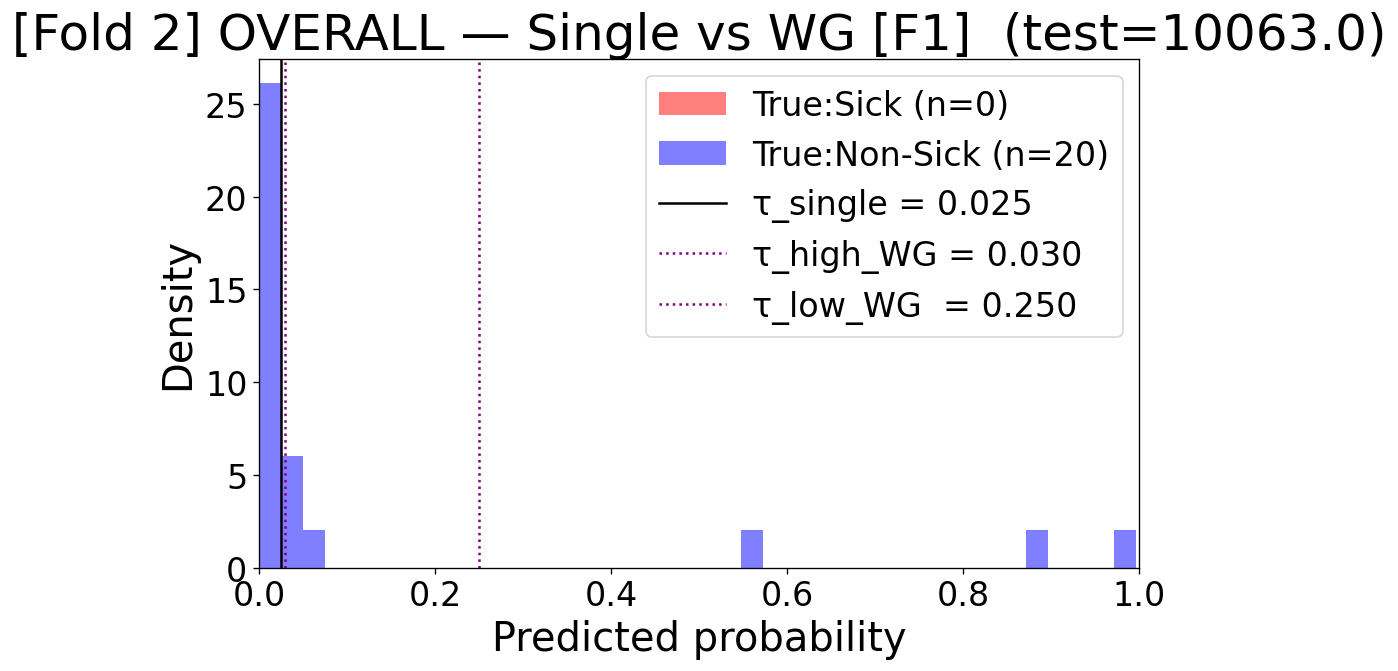

In [12]:
# ===== Cell 5B++: 確率スコア分布（OVERALL/群別/各Fold）＋ τ の中央値/IQR 帯・±表記 =====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 設定 ----------
BINS = 40
LW = 1.5
FS_TITLE, FS_LABEL, FS_LEGEND, FS_TICK = 30, 24, 20, 20

# 色指定（ユーザ指定）
COLOR_SICK = "red"   # True:Sick
COLOR_NON  = "blue"  # True:Non-Sick

# 線色（しきい値）
COLOR_SINGLE = "black"
COLOR_GROUP  = "green"
COLOR_WG     = "purple"

# 出力フォルダ（新規作成）
RUN_ROOT = os.path.dirname(outpath("__dummy__"))
IMG_DIR  = os.path.join(RUN_ROOT, "PROBA_DIST_F1")
os.makedirs(IMG_DIR, exist_ok=True)

# ファイルパス
SAVE_OVERALL_SvG   = os.path.join(IMG_DIR, "OVERALL_SvGroup.png")
SAVE_OVERALL_SvWG  = os.path.join(IMG_DIR, "OVERALL_SvWG.png")
SAVE_BYGROUP_SvG   = os.path.join(IMG_DIR, "BYGROUP_SvGroup.png")
SAVE_BYGROUP_SvWG  = os.path.join(IMG_DIR, "BYGROUP_SvWG.png")

# ---------- 入力 ----------
GROUP_AWARE_DIR = os.path.join(OUT_DIR,"Cell5_F1","GROUP_AWARE", "F1")
os.makedirs(GROUP_AWARE_DIR, exist_ok=True)

def groupaware_path(filename: str) -> str:
    return os.path.join(GROUP_AWARE_DIR, filename)

pred_path = groupaware_path("GROUP_AWARE_PREDICTIONS.CSV")
fold_path = groupaware_path("GROUP_AWARE_THRESH_BY_FOLD.CSV")
if not (os.path.exists(pred_path) and os.path.exists(fold_path)):
    raise FileNotFoundError("[Cell5B++] 必要CSVが見つからない（F1版 Cell 5A を先に実行）")

df_pred = pd.read_csv(pred_path, encoding="utf-8-sig")
df_fold = pd.read_csv(fold_path, encoding="utf-8-sig")

# ---------- モード自動判定（F1 or BA） ----------
cols_f1 = {"high":"tau_high_GroupF1", "low":"tau_low_GroupF1", "wgh":"tau_high_WGF1", "wgl":"tau_low_WGF1"}
cols_ba = {"high":"tau_high_GroupBA", "low":"tau_low_GroupBA", "wgh":"tau_high_WGBA", "wgl":"tau_low_WGBA"}

if all(c in df_fold.columns for c in [cols_f1["high"], cols_f1["low"]]):
    mode = "F1"
    c_high, c_low, c_wgh, c_wgl = cols_f1["high"], cols_f1["low"], cols_f1["wgh"], cols_f1["wgl"]
    pred_group_col = "y_pred_group_F1"
elif all(c in df_fold.columns for c in [cols_ba["high"], cols_ba["low"]]):
    mode = "BA"
    c_high, c_low, c_wgh, c_wgl = cols_ba["high"], cols_ba["low"], cols_ba["wgh"], cols_ba["wgl"]
    pred_group_col = "y_pred_group_BA"
else:
    raise RuntimeError("[Cell5B++] しきい値列が見つからない（F1/BAどちらかのCell 5Aの出力が必要）")

# ---------- 集約: 中央値/IQR（Q1〜Q3） ----------
def _qstats(s):
    s = pd.to_numeric(s, errors="coerce")
    s = s[np.isfinite(s)]
    if s.size == 0:
        return np.nan, np.nan, np.nan, np.nan  # med, q1, q3, half_iqr
    med = float(np.nanmedian(s))
    q1, q3 = np.nanpercentile(s, [25, 75])
    half = float((q3 - q1)/2.0)
    return float(med), float(q1), float(q3), half

tau_single_med, tau_single_q1, tau_single_q3, tau_single_half = _qstats(df_fold["tau_single"])
tau_high_med,   tau_high_q1,   tau_high_q3,   tau_high_half   = _qstats(df_fold[c_high])
tau_low_med,    tau_low_q1,    tau_low_q3,    tau_low_half    = _qstats(df_fold[c_low])
tau_high_wg,    tau_high_wg_q1, tau_high_wg_q3, tau_high_wg_half = _qstats(df_fold[c_wgh]) if c_wgh in df_fold.columns else (np.nan, np.nan, np.nan, np.nan)
tau_low_wg,     tau_low_wg_q1,  tau_low_wg_q3,  tau_low_wg_half  = _qstats(df_fold[c_wgl]) if c_wgl in df_fold.columns else (np.nan, np.nan, np.nan, np.nan)

# ---------- データ分解 ----------
proba = pd.to_numeric(df_pred["proba"], errors="coerce").values
ytrue = pd.to_numeric(df_pred["y_true"], errors="coerce").values.astype(int)
grp   = df_pred["group"].astype(str).str.strip()

p_sick = proba[ytrue == 1]   # True:Sick
p_non  = proba[ytrue == 0]   # True:Non-Sick
n_sick, n_non = len(p_sick), len(p_non)

maskH = (grp == "High"); maskL = (grp == "Low")

# ---------- ユーティリティ ----------
def _style_axes(ax, title=None):
    if title: ax.set_title(title, fontsize=FS_TITLE)
    ax.set_xlabel("Predicted probability", fontsize=FS_LABEL)
    ax.set_ylabel("Density", fontsize=FS_LABEL)
    ax.tick_params(axis="both", labelsize=FS_TICK)
    ax.set_xlim(0, 1)

def _hist_overall(ax):
    ax.hist(p_sick, bins=BINS, density=True, alpha=0.5, label=f"True:Sick (n={n_sick})", color=COLOR_SICK)
    ax.hist(p_non,  bins=BINS, density=True, alpha=0.5, label=f"True:Non-Sick (n={n_non})", color=COLOR_NON)

def _hist_bygroup(axes):
    # High
    p_sick_H = proba[(ytrue==1) & maskH]; p_non_H = proba[(ytrue==0) & maskH]
    axes[0].hist(p_sick_H, bins=BINS, density=True, alpha=0.5, label=f"True:Sick (n={len(p_sick_H)})", color=COLOR_SICK)
    axes[0].hist(p_non_H,  bins=BINS, density=True, alpha=0.5, label=f"True:Non-Sick (n={len(p_non_H)})", color=COLOR_NON)
    _style_axes(axes[0], "High group")
    # Low
    p_sick_L = proba[(ytrue==1) & maskL]; p_non_L = proba[(ytrue==0) & maskL]
    axes[1].hist(p_sick_L, bins=BINS, density=True, alpha=0.5, label=f"True:Sick (n={len(p_sick_L)})", color=COLOR_SICK)
    axes[1].hist(p_non_L,  bins=BINS, density=True, alpha=0.5, label=f"True:Non-Sick (n={len(p_non_L)})", color=COLOR_NON)
    _style_axes(axes[1], "Low group")

def _vline_with_iqr(ax, x_med, q1, q3, color, ls, label_core):
    if np.isfinite(x_med):
        ax.axvline(x_med, color=color, linestyle=ls, linewidth=LW,
                   label=f"{label_core} = {x_med:.3f} ± {(q3-q1)/2:.3f}" if (np.isfinite(q1) and np.isfinite(q3)) else f"{label_core} = {x_med:.3f}")
    if np.isfinite(q1) and np.isfinite(q3):
        ax.axvspan(q1, q3, color=color, alpha=0.12)

# ---------- 1) OVERALL: Single vs Group（中央値・IQR帯・±表記） ----------
fig, ax = plt.subplots(figsize=(9,6))
_hist_overall(ax)
_vline_with_iqr(ax, tau_single_med, tau_single_q1, tau_single_q3, COLOR_SINGLE, "-", "τ_single")
_vline_with_iqr(ax, tau_high_med,   tau_high_q1,   tau_high_q3,   COLOR_GROUP,  "--", f"τ_high_{mode}")
_vline_with_iqr(ax, tau_low_med,    tau_low_q1,    tau_low_q3,    COLOR_GROUP,  "--", f"τ_low_{mode}")
_style_axes(ax, title=f"Probability distribution (OVERALL) — Single vs Group [{mode}]")
ax.legend(fontsize=FS_LEGEND)
plt.tight_layout(); plt.savefig(SAVE_OVERALL_SvG, dpi=300); plt.close()
print(f"[Cell5B++] Saved -> {SAVE_OVERALL_SvG}")

# ---------- 2) OVERALL: Single vs WG（中央値・IQR帯・±表記） ----------
fig, ax = plt.subplots(figsize=(9,6))
_hist_overall(ax)
_vline_with_iqr(ax, tau_single_med, tau_single_q1, tau_single_q3, COLOR_SINGLE, "-", "τ_single")
_vline_with_iqr(ax, tau_high_wg,    tau_high_wg_q1, tau_high_wg_q3, COLOR_WG, ":", "τ_high_WG")
_vline_with_iqr(ax, tau_low_wg,     tau_low_wg_q1,  tau_low_wg_q3,  COLOR_WG, ":", "τ_low_WG")
_style_axes(ax, title=f"Probability distribution (OVERALL) — Single vs WG [{mode}]")
ax.legend(fontsize=FS_LEGEND)
plt.tight_layout(); plt.savefig(SAVE_OVERALL_SvWG, dpi=300); plt.close()
print(f"[Cell5B++] Saved -> {SAVE_OVERALL_SvWG}")

# ---------- 3) BY_GROUP: Single vs Group（各群パネルに該当の IQR帯） ----------
fig, axes = plt.subplots(2, 1, figsize=(9,10), sharex=True)
_hist_bygroup(axes)
# Single は両段に表示
_vline_with_iqr(axes[0], tau_single_med, tau_single_q1, tau_single_q3, COLOR_SINGLE, "-", "τ_single")
_vline_with_iqr(axes[1], tau_single_med, tau_single_q1, tau_single_q3, COLOR_SINGLE, "-", "τ_single")
# High 段に High の Group τ、Low 段に Low の Group τ
_vline_with_iqr(axes[0], tau_high_med, tau_high_q1, tau_high_q3, COLOR_GROUP, "--", f"τ_high_{mode}")
_vline_with_iqr(axes[1], tau_low_med,  tau_low_q1,  tau_low_q3,  COLOR_GROUP, "--", f"τ_low_{mode}")
axes[0].legend(fontsize=FS_LEGEND); axes[1].legend(fontsize=FS_LEGEND)
plt.tight_layout(); plt.savefig(SAVE_BYGROUP_SvG, dpi=300); plt.close()
print(f"[Cell5B++] Saved -> {SAVE_BYGROUP_SvG}")

# ---------- 4) BY_GROUP: Single vs WG（各群パネルに該当の IQR帯） ----------
fig, axes = plt.subplots(2, 1, figsize=(9,10), sharex=True)
_hist_bygroup(axes)
_vline_with_iqr(axes[0], tau_single_med, tau_single_q1, tau_single_q3, COLOR_SINGLE, "-", "τ_single")
_vline_with_iqr(axes[1], tau_single_med, tau_single_q1, tau_single_q3, COLOR_SINGLE, "-", "τ_single")
_vline_with_iqr(axes[0], tau_high_wg, tau_high_wg_q1, tau_high_wg_q3, COLOR_WG, ":", "τ_high_WG")
_vline_with_iqr(axes[1], tau_low_wg,  tau_low_wg_q1,  tau_low_wg_q3,  COLOR_WG, ":", "τ_low_WG")
axes[0].legend(fontsize=FS_LEGEND); axes[1].legend(fontsize=FS_LEGEND)
plt.tight_layout(); plt.savefig(SAVE_BYGROUP_SvWG, dpi=300); plt.close()
print(f"[Cell5B++] Saved -> {SAVE_BYGROUP_SvWG}")

# ---------- 5) Fold単位：OVERALL の確率分布と各Foldの τ（Single vs Group / Single vs WG） ----------
#   - 各Foldのテストサンプルのみでヒストを作図
#   - しきい値は「そのFold行」の値を直接表示（±は不要／IQR帯は使わない）
for _, row in df_fold.iterrows():
    fid = int(row["fold_id"]) if "fold_id" in row else None
    test_id = str(row.get("test_id", f"fold{fid}"))
    sub = df_pred[df_pred["fold_id"] == fid] if "fold_id" in df_pred.columns and fid is not None else df_pred.copy()

    p = pd.to_numeric(sub["proba"], errors="coerce").values
    yt = pd.to_numeric(sub["y_true"], errors="coerce").values.astype(int)
    p_s, p_n = p[yt==1], p[yt==0]

    # 値（このFoldの τ）
    t_single = float(row["tau_single"])
    t_high   = float(row[c_high]) if c_high in row else np.nan
    t_low    = float(row[c_low])  if c_low  in row else np.nan
    t_high_w = float(row[c_wgh])  if c_wgh  in row else np.nan
    t_low_w  = float(row[c_wgl])  if c_wgl  in row else np.nan

    # 出力パス
    p_sg  = os.path.join(IMG_DIR, f"FOLD{fid:02d}_{test_id}_OVERALL_SvGroup.png")
    p_wg  = os.path.join(IMG_DIR, f"FOLD{fid:02d}_{test_id}_OVERALL_SvWG.png")

    # Single vs Group
    fig, ax = plt.subplots(figsize=(9,6))
    ax.hist(p_s, bins=BINS, density=True, alpha=0.5, label=f"True:Sick (n={len(p_s)})", color=COLOR_SICK)
    ax.hist(p_n, bins=BINS, density=True, alpha=0.5, label=f"True:Non-Sick (n={len(p_n)})", color=COLOR_NON)
    if np.isfinite(t_single): ax.axvline(t_single, color=COLOR_SINGLE, linestyle="-", linewidth=LW, label=f"τ_single = {t_single:.3f}")
    if np.isfinite(t_high):   ax.axvline(t_high,   color=COLOR_GROUP,  linestyle="--", linewidth=LW, label=f"τ_high_{mode} = {t_high:.3f}")
    if np.isfinite(t_low):    ax.axvline(t_low,    color=COLOR_GROUP,  linestyle="--", linewidth=LW, label=f"τ_low_{mode}  = {t_low:.3f}")
    _style_axes(ax, title=f"[Fold {fid}] OVERALL — Single vs Group [{mode}]  (test={test_id})")
    ax.legend(fontsize=FS_LEGEND)
    plt.tight_layout(); plt.savefig(p_sg, dpi=300); plt.close()
    print(f"[Cell5B++] Saved -> {p_sg}")

    # Single vs WG
    fig, ax = plt.subplots(figsize=(9,6))
    ax.hist(p_s, bins=BINS, density=True, alpha=0.5, label=f"True:Sick (n={len(p_s)})", color=COLOR_SICK)
    ax.hist(p_n, bins=BINS, density=True, alpha=0.5, label=f"True:Non-Sick (n={len(p_n)})", color=COLOR_NON)
    if np.isfinite(t_single): ax.axvline(t_single, color=COLOR_SINGLE, linestyle="-", linewidth=LW, label=f"τ_single = {t_single:.3f}")
    if np.isfinite(t_high_w): ax.axvline(t_high_w, color=COLOR_WG,     linestyle=":", linewidth=LW, label=f"τ_high_WG = {t_high_w:.3f}")
    if np.isfinite(t_low_w):  ax.axvline(t_low_w,  color=COLOR_WG,     linestyle=":", linewidth=LW, label=f"τ_low_WG  = {t_low_w:.3f}")
    _style_axes(ax, title=f"[Fold {fid}] OVERALL — Single vs WG [{mode}]  (test={test_id})")
    ax.legend(fontsize=FS_LEGEND)
    plt.tight_layout(); plt.savefig(p_wg, dpi=300); plt.close()
    print(f"[Cell5B++] Saved -> {p_wg}")

print(f"[Cell5B++] All images saved in: {IMG_DIR}")


In [16]:
# ===== Cell 5A (FINAL, BA専用): inner-LOSO τ最適化（連結val）→ outer予測・評価 =====
# 前提: Cell1〜4 実行済み（X_all, y_all, groups, SUBJECT_META, choose_inner_folds_loso 等）

import os
import json
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# ---------------- GROUP_AWARE 出力先（BA） ----------------
MODE_TAG = "BA"
GROUP_AWARE_DIR = os.path.join(OUT_DIR,"Cell5_BA", "GROUP_AWARE", MODE_TAG)
os.makedirs(GROUP_AWARE_DIR, exist_ok=True)

def groupaware_out(filename: str) -> str:
    path = os.path.join(GROUP_AWARE_DIR, filename)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    return path

# ---------------- 基本チェック ----------------
req = ["X_all","y_all","groups","SUBJECT_META",
       "choose_inner_folds_loso","fit_classifier","predict_positive_score","outpath"]
missing = [v for v in req if v not in globals()]
if missing:
    raise RuntimeError(f"[Cell5A-BA] 未定義の変数/関数があります: {missing}")

if "MSSQ_group" not in SUBJECT_META.columns and "MSSQ_group" not in SUBJECT_META.index.names:
    raise RuntimeError("[Cell5A-BA] SUBJECT_META に MSSQ_group 列（または index）が必要である．")

# ---------------- 入力整形 ----------------
X_base = X_all.astype(np.float32)
y_base = y_all.astype(int)
g_base = groups.astype(str)

# MSSQ group マッピング（High/Lowに正規化）
if "subject_id" in SUBJECT_META.columns:
    mapper = SUBJECT_META.set_index("subject_id")["MSSQ_group"].astype(str).to_dict()
else:
    mapper = SUBJECT_META["MSSQ_group"].astype(str).to_dict()

fair_groups = (
    g_base.map(mapper)
          .astype(str)
          .str.strip()
          .str.lower()
          .map({"high": "High", "low": "Low"})
)
if fair_groups.isna().any():
    raise RuntimeError(f"[Cell5A-BA] MSSQ_group 未割当ID: {sorted(set(g_base[fair_groups.isna()]))}")

# ---------------- 特徴選抜（Cell3A-Subset の JSON のみ使用＋MSSQ/VIMSSQオプション） ----------------
subset_primary = f"TOP{int(globals().get('TOP_SUBSET_K', 15))}_SUBSET_BEST.json"
subset_candidates = [subset_primary, "TOP10_SUBSET_BEST.json"]
subset_json = None
for name in subset_candidates:
    cand = outpath(name)
    if os.path.exists(cand):
        subset_json = cand
        break

if subset_json is None:
    raise FileNotFoundError(
        "[Cell5A-BA] TOP*_SUBSET_BEST.json が見つかりません。Cell3A-Subset を実行してください。"
    )

with open(subset_json, "r", encoding="utf-8") as f:
    subset_info = json.load(f)

raw_features = subset_info.get("features", [])
if not raw_features:
    raise RuntimeError(f"[Cell5A-BA] JSON 内に 'features' が空です -> {os.path.basename(subset_json)}")

# X_all に実在する特徴だけに絞る
feature_order = [f for f in raw_features if f in X_base.columns]
if not feature_order:
    raise RuntimeError(
        f"[Cell5A-BA] JSON の features が X_all に1つも存在しません: {raw_features}"
    )

# MSSQ / VIMSSQ を任意で追加
extra_traits = []
if globals().get("USE_MSSQ_FEATURE", False) and "MSSQ" in X_base.columns:
    extra_traits.append("MSSQ")
if globals().get("USE_VIMSSQ_FEATURE", False) and "VIMSSQ" in X_base.columns:
    extra_traits.append("VIMSSQ")

# 既に含まれていないものだけ追加
extra_traits = [f for f in extra_traits if f not in feature_order]

feats_k = feature_order + extra_traits
best_k = len(feats_k)

print(f"[Cell5A-BA] Using subset features from {os.path.basename(subset_json)}")
print(f"[Cell5A-BA] JSON features (base) k={len(feature_order)}: {feature_order}")
if extra_traits:
    print(f"[Cell5A-BA] 追加で使用する属性特徴: {extra_traits}")
print(f"[Cell5A-BA] 最終的に使用する特徴数 = {best_k}")

X_k = X_base[feats_k]

if VERBOSE:
    print(f"[DBG-BA] 使用特徴数: {len(feats_k)}")
    print("[DBG-BA] 使用特徴一覧 (feats_k):")
    for i, f_name in enumerate(feats_k, start=1):
        print(f"  {i:2d}: {f_name}")

# ---------------- 指標・評価ユーティリティ（BA専用） ----------------
def _conf_from_preds(y_true: np.ndarray, y_pred: np.ndarray):
    TN, FP, FN, TP = skm.confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return TP, FP, FN, TN

def _ba_from_conf(TP, FP, FN, TN) -> float:
    TP = float(TP); FP = float(FP); FN = float(FN); TN = float(TN)
    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # Sensitivity/TPR
    tnr = TN / (TN + FP) if (TN + FP) > 0 else 0.0  # Specificity/TNR
    return 0.5 * (tpr + tnr)

def _ba_binary(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    TP, FP, FN, TN = _conf_from_preds(y_true, y_pred)
    return _ba_from_conf(TP, FP, FN, TN)

def _grid(l, r, steps):
    l = float(max(0.0, l)); r = float(min(1.0, r))
    if l > r: l, r = r, l
    return np.linspace(l, r, int(steps), dtype=float)

# ---------------- τ最適化（Single / WG-BA / Group-BA） ----------------
def _single_tau_opt(scores: np.ndarray, y: np.ndarray):
    # coarse
    cands = _grid(0.0, 1.0, COARSE_STEPS)
    ba_vec = []
    for t in cands:
        yhat = (scores >= t).astype(int)
        ba_vec.append(_ba_binary(y, yhat))
    ba_vec = np.asarray(ba_vec)
    idx = int(np.nanargmax(ba_vec)); tau0 = float(cands[idx]); best0 = float(ba_vec[idx])

    # fine around tau0
    left  = max(0.0, tau0 - FINE_MARGIN)
    right = min(1.0, tau0 + FINE_MARGIN)
    cands2 = _grid(left, right, FINE_STEPS)
    ba_vec2 = []
    for t in cands2:
        yhat = (scores >= t).astype(int)
        ba_vec2.append(_ba_binary(y, yhat))
    ba_vec2 = np.asarray(ba_vec2)
    idx2 = int(np.nanargmax(ba_vec2)); tau = float(cands2[idx2]); best = float(ba_vec2[idx2])

    return {"tau": tau, "BA_val": best, "tau_coarse": tau0, "BA_coarse": best0}

def _wg_ba_opt_joint(scores: np.ndarray, y: np.ndarray, grp: np.ndarray):
    """
    Fair-MinBA（最悪群BAの最大化）を 2Dグリッド（τH×τL）で探索する．
    戻り値: {"tauH","tauL","BA_H_val","BA_L_val","WG_BA_val","BA_pooled_val"}
    """
    maskH = (grp == "High"); maskL = (grp == "Low")
    if (maskH.sum()==0) or (maskL.sum()==0):
        raise RuntimeError("[WG-BA] 連結valに High/Low の両群が必要（どちらかが0件）")

    sH, yH = scores[maskH], y[maskH]
    sL, yL = scores[maskL], y[maskL]

    candH = _grid(0.0, 1.0, COARSE_STEPS)
    candL = _grid(0.0, 1.0, COARSE_STEPS)

    def _ba_vec(s, yy, cands):
        ba = np.empty_like(cands)
        for i, t in enumerate(cands):
            yhat = (s >= t).astype(int)
            ba[i] = _ba_binary(yy, yhat)
        return ba

    baH = _ba_vec(sH, yH, candH)
    baL = _ba_vec(sL, yL, candL)

    best = {"WG": -np.inf, "pooled": -np.inf, "tH": 0.5, "tL": 0.5, "BAH": 0.0, "BAL": 0.0}
    for i, tH in enumerate(candH):
        wg_row = np.minimum(baH[i], baL)
        j = int(np.nanargmax(wg_row))
        WG = float(wg_row[j])

        yhatH = (sH >= tH).astype(int)
        yhatL = (sL >= candL[j]).astype(int)
        BA_pooled = _ba_binary(
            np.concatenate([yH, yL]),
            np.concatenate([yhatH, yhatL])
        )

        cand = {"WG": WG, "pooled": float(BA_pooled),
                "tH": float(tH), "tL": float(candL[j]),
                "BAH": float(baH[i]), "BAL": float(baL[j])}

        # tie-break: pooled BA → |τH-τL| 小 → (τH,τL) 辞書順小
        def _is_better(cur, new):
            if new["WG"] > cur["WG"]: return True
            if new["WG"] < cur["WG"]: return False
            if new["pooled"] > cur["pooled"]: return True
            if new["pooled"] < cur["pooled"]: return False
            if abs(new["tH"]-new["tL"]) < abs(cur["tH"]-cur["tL"]): return True
            if abs(new["tH"]-new["tL"]) > abs(cur["tH"]-cur["tL"]): return False
            if (new["tH"], new["tL"]) < (cur["tH"], cur["tL"]): return True
            return False

        if _is_better(best, cand):
            best = cand

    # fine (box refine)
    lH = max(0.0, best["tH"] - FINE_MARGIN); rH = min(1.0, best["tH"] + FINE_MARGIN)
    lL = max(0.0, best["tL"] - FINE_MARGIN); rL = min(1.0, best["tL"] + FINE_MARGIN)
    candH2 = _grid(lH, rH, FINE_STEPS)
    candL2 = _grid(lL, rL, FINE_STEPS)

    baH2 = _ba_vec(sH, yH, candH2)
    baL2 = _ba_vec(sL, yL, candL2)

    best2 = dict(best)
    for i, tH in enumerate(candH2):
        wg_row = np.minimum(baH2[i], baL2)
        j = int(np.nanargmax(wg_row))
        WG = float(wg_row[j])

        yhatH = (sH >= tH).astype(int)
        yhatL = (sL >= candL2[j]).astype(int)
        BA_pooled = _ba_binary(
            np.concatenate([yH, yL]),
            np.concatenate([yhatH, yhatL])
        )
        cand = {"WG": WG, "pooled": float(BA_pooled),
                "tH": float(tH), "tL": float(candL2[j]),
                "BAH": float(baH2[i]), "BAL": float(baL2[j])}

        if (cand["WG"] > best2["WG"] or
            (cand["WG"] == best2["WG"] and (
                cand["pooled"] > best2["pooled"] or
                (cand["pooled"] == best2["pooled"] and (
                    abs(cand["tH"]-cand["tL"]) < abs(best2["tH"]-best2["tL"]) or
                    (abs(cand["tH"]-cand["tL"]) == abs(best2["tH"]-best2["tL"]) and
                     (cand["tH"], cand["tL"]) < (best2["tH"], best2["tL"]))
                ))
            ))):
            best2 = cand

    return {
        "tauH": best2["tH"], "tauL": best2["tL"],
        "BA_H_val": best2["BAH"], "BA_L_val": best2["BAL"],
        "WG_BA_val": best2["WG"], "BA_pooled_val": best2["pooled"],
    }

def _group_ba_opt(scores: np.ndarray, y: np.ndarray, grp: np.ndarray):
    # 2Dグリッド（τH×τL）で pooled BA 最大化（coarse→fine）
    maskH = (grp == "High"); maskL = (grp == "Low")
    if (maskH.sum()==0) or (maskL.sum()==0):
        raise RuntimeError("[Group-BA] 連結valに High/Low の両群が必要（どちらかが0件）")

    sH, yH = scores[maskH], y[maskH]
    sL, yL = scores[maskL], y[maskL]

    def _pooled_ba_for(tH, tL):
        yhatH = (sH >= tH).astype(int)
        yhatL = (sL >= tL).astype(int)
        y_true = np.concatenate([yH, yL])
        y_pred = np.concatenate([yhatH, yhatL])
        return _ba_binary(y_true, y_pred)

    candH = _grid(0.0, 1.0, COARSE_STEPS)
    candL = _grid(0.0, 1.0, COARSE_STEPS)
    best = {"BA_val": -np.inf, "tauH": None, "tauL": None}
    for tH in candH:
        ba_vec = np.empty_like(candL)
        for j, tL in enumerate(candL):
            ba_vec[j] = _pooled_ba_for(tH, tL)
        jmax = int(np.nanargmax(ba_vec))
        if float(ba_vec[jmax]) > best["BA_val"]:
            best.update({"BA_val": float(ba_vec[jmax]), "tauH": float(tH), "tauL": float(candL[jmax])})

    # fine
    lH = max(0.0, best["tauH"] - FINE_MARGIN); rH = min(1.0, best["tauH"] + FINE_MARGIN)
    lL = max(0.0, best["tauL"] - FINE_MARGIN); rL = min(1.0, best["tauL"] + FINE_MARGIN)
    candH2 = _grid(lH, rH, FINE_STEPS); candL2 = _grid(lL, rL, FINE_STEPS)

    best2 = dict(best)
    for tH in candH2:
        ba_vec2 = np.empty_like(candL2)
        for j, tL in enumerate(candL2):
            ba_vec2[j] = _pooled_ba_for(tH, tL)
        jmax = int(np.nanargmax(ba_vec2))
        if float(ba_vec2[jmax]) > best2["BA_val"]:
            best2.update({"BA_val": float(ba_vec2[jmax]), "tauH": float(tH), "tauL": float(candL2[jmax])})

    return best2  # {"tauH","tauL","BA_val"}

# ---------------- outer LOSO with inner concatenation ----------------
logo_outer = LeaveOneGroupOut()
rows, pred_rows = [], []

for fold_id, (tr_idx, te_idx) in enumerate(logo_outer.split(X_k, y_base.values, g_base.values), start=1):
    train_mask = pd.Series(False, index=g_base.index); train_mask.iloc[tr_idx] = True
    test_mask  = pd.Series(False, index=g_base.index);  test_mask.iloc[te_idx]  = True
    test_sid = g_base.iloc[te_idx].iloc[0]

    # ===== inner folds =====
    inner_ids   = sorted(g_base[train_mask].unique())
    inner_folds = choose_inner_folds_loso(inner_ids)
    if VERBOSE:
        print(f"[inner folds-BA] {len(inner_folds)} splits -> val subjects = {', '.join(inner_ids)}")

    # 連結valの器
    val_scores_all, val_y_all, val_grp_all = [], [], []

    # --- inner train に両群が居るか（群別τの前提） ---
    inner_train_groups = fair_groups[train_mask]
    if not (("High" in set(inner_train_groups)) and ("Low" in set(inner_train_groups))):
        raise RuntimeError(f"[Cell5A-BA] fold{fold_id}: inner-train に両群(High/Low)が必要（群別τの前提）")

    # ===== inner: train→val 予測の連結 =====
    for inner_val in inner_folds:
        val_mask  = g_base.isin(inner_val) & train_mask
        trn_mask  = train_mask & (~val_mask)
        if not trn_mask.any() or not val_mask.any():
            continue

        X_tr, y_tr = X_k[trn_mask], y_base[trn_mask]
        X_vl, y_vl = X_k[val_mask], y_base[val_mask]
        grp_vl     = fair_groups[val_mask].to_numpy()

        # inner 学習
        model_inner = fit_classifier(X_tr, y_tr)
        sc_vl = predict_positive_score(model_inner, X_vl).astype(float)

        # 連結（生の val 予測）
        val_scores_all.append(sc_vl)
        val_y_all.append(y_vl.to_numpy())
        val_grp_all.append(grp_vl)

        if VERBOSE:
            nH = int((grp_vl=="High").sum()); nL = int((grp_vl=="Low").sum())
            print(f"[DBG-BA] fold{fold_id}: inner_val size={len(y_vl):3d}  High={nH} Low={nL}")

    # 連結
    if len(val_scores_all) == 0:
        raise RuntimeError(f"[Cell5A-BA] fold{fold_id}: inner validation が空である．")
    s_val = np.concatenate(val_scores_all)
    y_val = np.concatenate(val_y_all)
    g_val = np.concatenate(val_grp_all)

    # ===== 連結valで一度だけ τ を最適化（BA） =====
    res_single = _single_tau_opt(s_val, y_val)
    tau_single = float(res_single["tau"])

    res_wg = _wg_ba_opt_joint(s_val, y_val, g_val)
    tauH_wg, tauL_wg = float(res_wg["tauH"]), float(res_wg["tauL"])

    res_group = _group_ba_opt(s_val, y_val, g_val)
    tauH_grp, tauL_grp = float(res_group["tauH"]), float(res_group["tauL"])

    if VERBOSE:
        print(f"[DBG-BA] fold{fold_id}: tau_single={tau_single:.6f} | "
              f"Group-BA(tH,tL)=({tauH_grp:.6f},{tauL_grp:.6f}) | "
              f"WG-BA(tH,tL)=({tauH_wg:.6f},{tauL_wg:.6f})")

    # ===== outer test =====
    X_tr_o, y_tr_o = X_k[train_mask], y_base[train_mask]
    X_te_o, y_te_o = X_k[test_mask],  y_base[test_mask]
    grp_te         = fair_groups[test_mask].to_numpy()

    model_outer = fit_classifier(X_tr_o, y_tr_o)
    sc_te = predict_positive_score(model_outer, X_te_o).astype(float)

    y_true_te = y_te_o.to_numpy()
    yhat_single = (sc_te >= tau_single).astype(int)
    yhat_groupBA = (sc_te >= np.where(grp_te=="High", tauH_grp, tauL_grp)).astype(int)
    yhat_wgBA    = (sc_te >= np.where(grp_te=="High", tauH_wg,  tauL_wg )).astype(int)

    BA_single = _ba_binary(y_true_te, yhat_single)
    BA_group  = _ba_binary(y_true_te, yhat_groupBA)
    BA_wg     = _ba_binary(y_true_te, yhat_wgBA)

    if VERBOSE:
        same_grp = bool(np.array_equal(yhat_single, yhat_groupBA))
        same_wg  = bool(np.array_equal(yhat_single, yhat_wgBA))
        nH_te = int((grp_te=="High").sum()); nL_te = int((grp_te=="Low").sum())
        print(f"[DBG-BA] fold{fold_id}: TEST High={nH_te} Low={nL_te} | "
              f"Single==Group-BA: {same_grp}  Single==WG-BA: {same_wg} | "
              f"BA(single, group, wg)=({BA_single:.3f}, {BA_group:.3f}, {BA_wg:.3f})")

    rows.append({
        "fold_id": int(fold_id),
        "test_id": str(test_sid),
        "best_k": int(best_k),
        "tau_single": float(tau_single),
        "tau_high_GroupBA": float(tauH_grp), "tau_low_GroupBA": float(tauL_grp),
        "tau_high_WGBA": float(tauH_wg),     "tau_low_WGBA": float(tauL_wg),
        "BA_single": float(BA_single),
        "BA_group":  float(BA_group),
        "BA_group_WG": float(BA_wg),
        "n_test": int(len(y_te_o)),
    })

    # 予測詳細（BA専用命名）
    for yy, ss, gg, ys, yg, yw in zip(y_te_o, sc_te, grp_te, yhat_single, yhat_groupBA, yhat_wgBA):
        pred_rows.append({
            "fold_id": int(fold_id),
            "test_id": str(test_sid),
            "y_true": int(yy),
            "proba": float(ss),
            "group": str(gg),
            "y_pred_single": int(ys),
            "y_pred_group_BA": int(yg),
            "y_pred_group_WG": int(yw),
        })
    
    print(f"[DBG-BA] fold{fold_id}: WG-joint val -> "
          f"BA_H={res_wg['BA_H_val']:.3f}, BA_L={res_wg['BA_L_val']:.3f}, "
          f"WG(BA)={res_wg['WG_BA_val']:.3f}, pooled(BA)={res_wg['BA_pooled_val']:.3f}, "
          f"(tH,tL)=({tauH_wg:.4f},{tauL_wg:.4f})")

# ---------------- 出力 ----------------
df_fold = pd.DataFrame(rows)
df_pred = pd.DataFrame(pred_rows)
df_fold.to_csv(groupaware_out("GROUP_AWARE_THRESH_BY_FOLD.CSV"), index=False, encoding="utf-8-sig")
df_pred.to_csv(groupaware_out("GROUP_AWARE_PREDICTIONS.CSV"), index=False, encoding="utf-8-sig")

# 参考: プールAUC（確率は共通なので1つ）
auc_pool = float(roc_auc_score(df_pred["y_true"].to_numpy(), df_pred["proba"].to_numpy()))

def _pooled_ba(col):
    y_true = df_pred["y_true"].to_numpy()
    yhat   = df_pred[col].to_numpy().astype(int)
    return _ba_binary(y_true, yhat)

summary = {
    "best_k": int(best_k),
    "AUC_pooled": auc_pool,
    "BA_pooled_single": _pooled_ba("y_pred_single"),
    "BA_pooled_group":  _pooled_ba("y_pred_group_BA"),
    "BA_pooled_group_WG": _pooled_ba("y_pred_group_WG"),
    "metric": "BA",
    "n_samples": int(len(df_pred)),
    "n_pos": int((df_pred["y_true"]==1).sum()),
    "n_neg": int((df_pred["y_true"]==0).sum()),
}
pd.DataFrame([summary]).to_csv(groupaware_out("GROUP_AWARE_SUMMARY.CSV"), index=False, encoding="utf-8-sig")
print(f"[Cell5A-BA] Done: outer folds={len(df_fold)}, pooled AUC={auc_pool:.3f}")
print(f"[Cell5A-BA] Summary: {summary}")

# ---------------- 混同行列プロット（BA専用タイトル） ----------------
def _draw_cm(cm, title, path):
    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(cm, cmap="Blues", vmin=0, vmax=max(cm.max(),1))
    labels = np.array([["TN","FP"],["FN","TP"]])
    for i in range(2):
        for j in range(2):
            val = int(cm[i,j])
            color = "white" if val > 0.6*im.get_clim()[1] else "black"
            ax.text(j, i, f"{labels[i,j]}\n{val}", ha="center", va="center",
                    fontsize=18, fontweight="bold", color=color)
    ax.set_xticks([0,1]); ax.set_xticklabels(["Pred:0","Pred:1"])
    ax.set_yticks([0,1]); ax.set_yticklabels(["True:0","True:1"], rotation=90, va="center")
    ax.set_title(title); ax.grid(False)
    plt.tight_layout(); plt.savefig(path, dpi=300); plt.close()

y_pool = df_pred["y_true"].to_numpy()
cm_single = skm.confusion_matrix(y_pool, df_pred["y_pred_single"],   labels=[0,1])
cm_group  = skm.confusion_matrix(y_pool, df_pred["y_pred_group_BA"], labels=[0,1])
cm_wg     = skm.confusion_matrix(y_pool, df_pred["y_pred_group_WG"], labels=[0,1])

_draw_cm(cm_single, f"Cell5A Single τ (BA={summary['BA_pooled_single']:.3f})",
         outpath("CONFMAT_CELL5A_SINGLE(BA).png"))
_draw_cm(cm_group,  f"Cell5A Group-BA τ (BA={summary['BA_pooled_group']:.3f})",
         outpath("CONFMAT_CELL5A_GROUP(BA).png"))
_draw_cm(cm_wg,     f"Cell5A WG-BA τ (BA={summary['BA_pooled_group_WG']:.3f})",
         outpath("CONFMAT_CELL5A_WG(BA).png"))
print("[Cell5A-BA] Confusion matrices saved -> CONFMAT_CELL5A_*.png")


[Cell5A-BA] Using subset features from TOP10_SUBSET_BEST.json
[Cell5A-BA] JSON features (base) k=2: ['AB_meandiff_mean', 'watch_Sweat_Rate_std']
[Cell5A-BA] 最終的に使用する特徴数 = 2
[DBG-BA] 使用特徴数: 2
[DBG-BA] 使用特徴一覧 (feats_k):
   1: AB_meandiff_mean
   2: watch_Sweat_Rate_std
[inner folds] 16 splits -> val subjects = 10063, 10064, 10071, 10072, 10073, 10074, 10081, 10082, 10083, 10091, 10092, 10093, 10094, 10101, 10102, 10103
[inner folds-BA] 16 splits -> val subjects = 10063, 10064, 10071, 10072, 10073, 10074, 10081, 10082, 10083, 10091, 10092, 10093, 10094, 10101, 10102, 10103
[DBG-BA] fold1: inner_val size= 20  High=0 Low=20
[DBG-BA] fold1: inner_val size= 20  High=20 Low=0
[DBG-BA] fold1: inner_val size= 20  High=20 Low=0
[DBG-BA] fold1: inner_val size= 20  High=0 Low=20
[DBG-BA] fold1: inner_val size= 20  High=0 Low=20
[DBG-BA] fold1: inner_val size= 20  High=0 Low=20
[DBG-BA] fold1: inner_val size= 20  High=0 Low=20
[DBG-BA] fold1: inner_val size= 20  High=0 Low=20
[DBG-BA] fold1: inner_v

In [ ]:
# ===== Cell 5B++: 確率スコア分布（OVERALL/群別/各Fold）＋ τ の中央値/IQR 帯・±表記 =====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 設定 ----------
BINS = 40
LW = 1.5
FS_TITLE, FS_LABEL, FS_LEGEND, FS_TICK = 30, 24, 20, 20

# 色指定（ユーザ指定）
COLOR_SICK = "red"   # True:Sick
COLOR_NON  = "blue"  # True:Non-Sick

# 線色（しきい値）
COLOR_SINGLE = "black"
COLOR_GROUP  = "green"
COLOR_WG     = "purple"

# 出力フォルダ（新規作成）
RUN_ROOT = os.path.dirname(outpath("__dummy__"))
IMG_DIR  = os.path.join(RUN_ROOT, "PROBA_DIST_BA")
os.makedirs(IMG_DIR, exist_ok=True)

# ファイルパス
SAVE_OVERALL_SvG   = os.path.join(IMG_DIR, "OVERALL_SvGroup.png")
SAVE_OVERALL_SvWG  = os.path.join(IMG_DIR, "OVERALL_SvWG.png")
SAVE_BYGROUP_SvG   = os.path.join(IMG_DIR, "BYGROUP_SvGroup.png")
SAVE_BYGROUP_SvWG  = os.path.join(IMG_DIR, "BYGROUP_SvWG.png")

# ---------- 入力 ----------
GROUP_AWARE_DIR = os.path.join(OUT_DIR, "GROUP_AWARE", "BA")
os.makedirs(GROUP_AWARE_DIR, exist_ok=True)

def groupaware_path(filename: str) -> str:
    return os.path.join(GROUP_AWARE_DIR, filename)

pred_path = groupaware_path("GROUP_AWARE_PREDICTIONS.CSV")
fold_path = groupaware_path("GROUP_AWARE_THRESH_BY_FOLD.CSV")
if not (os.path.exists(pred_path) and os.path.exists(fold_path)):
    raise FileNotFoundError("[Cell5B++] 必要CSVが見つからない（BA版 Cell 5A を先に実行）")

df_pred = pd.read_csv(pred_path, encoding="utf-8-sig")
df_fold = pd.read_csv(fold_path, encoding="utf-8-sig")

# ---------- モード自動判定（F1 or BA） ----------
cols_f1 = {"high":"tau_high_GroupF1", "low":"tau_low_GroupF1", "wgh":"tau_high_WGF1", "wgl":"tau_low_WGF1"}
cols_ba = {"high":"tau_high_GroupBA", "low":"tau_low_GroupBA", "wgh":"tau_high_WGBA", "wgl":"tau_low_WGBA"}

if all(c in df_fold.columns for c in [cols_f1["high"], cols_f1["low"]]):
    mode = "F1"
    c_high, c_low, c_wgh, c_wgl = cols_f1["high"], cols_f1["low"], cols_f1["wgh"], cols_f1["wgl"]
    pred_group_col = "y_pred_group_F1"
elif all(c in df_fold.columns for c in [cols_ba["high"], cols_ba["low"]]):
    mode = "BA"
    c_high, c_low, c_wgh, c_wgl = cols_ba["high"], cols_ba["low"], cols_ba["wgh"], cols_ba["wgl"]
    pred_group_col = "y_pred_group_BA"
else:
    raise RuntimeError("[Cell5B++] しきい値列が見つからない（F1/BAどちらかのCell 5Aの出力が必要）")

# ---------- 集約: 中央値/IQR（Q1〜Q3） ----------
def _qstats(s):
    s = pd.to_numeric(s, errors="coerce")
    s = s[np.isfinite(s)]
    if s.size == 0:
        return np.nan, np.nan, np.nan, np.nan  # med, q1, q3, half_iqr
    med = float(np.nanmedian(s))
    q1, q3 = np.nanpercentile(s, [25, 75])
    half = float((q3 - q1)/2.0)
    return float(med), float(q1), float(q3), half

tau_single_med, tau_single_q1, tau_single_q3, tau_single_half = _qstats(df_fold["tau_single"])
tau_high_med,   tau_high_q1,   tau_high_q3,   tau_high_half   = _qstats(df_fold[c_high])
tau_low_med,    tau_low_q1,    tau_low_q3,    tau_low_half    = _qstats(df_fold[c_low])
tau_high_wg,    tau_high_wg_q1, tau_high_wg_q3, tau_high_wg_half = _qstats(df_fold[c_wgh]) if c_wgh in df_fold.columns else (np.nan, np.nan, np.nan, np.nan)
tau_low_wg,     tau_low_wg_q1,  tau_low_wg_q3,  tau_low_wg_half  = _qstats(df_fold[c_wgl]) if c_wgl in df_fold.columns else (np.nan, np.nan, np.nan, np.nan)

# ---------- データ分解 ----------
proba = pd.to_numeric(df_pred["proba"], errors="coerce").values
ytrue = pd.to_numeric(df_pred["y_true"], errors="coerce").values.astype(int)
grp   = df_pred["group"].astype(str).str.strip()

p_sick = proba[ytrue == 1]   # True:Sick
p_non  = proba[ytrue == 0]   # True:Non-Sick
n_sick, n_non = len(p_sick), len(p_non)

maskH = (grp == "High"); maskL = (grp == "Low")

# ---------- ユーティリティ ----------
def _style_axes(ax, title=None):
    if title: ax.set_title(title, fontsize=FS_TITLE)
    ax.set_xlabel("Predicted probability", fontsize=FS_LABEL)
    ax.set_ylabel("Density", fontsize=FS_LABEL)
    ax.tick_params(axis="both", labelsize=FS_TICK)
    ax.set_xlim(0, 1)

def _hist_overall(ax):
    ax.hist(p_sick, bins=BINS, density=True, alpha=0.5, label=f"True:Sick (n={n_sick})", color=COLOR_SICK)
    ax.hist(p_non,  bins=BINS, density=True, alpha=0.5, label=f"True:Non-Sick (n={n_non})", color=COLOR_NON)

def _hist_bygroup(axes):
    # High
    p_sick_H = proba[(ytrue==1) & maskH]; p_non_H = proba[(ytrue==0) & maskH]
    axes[0].hist(p_sick_H, bins=BINS, density=True, alpha=0.5, label=f"True:Sick (n={len(p_sick_H)})", color=COLOR_SICK)
    axes[0].hist(p_non_H,  bins=BINS, density=True, alpha=0.5, label=f"True:Non-Sick (n={len(p_non_H)})", color=COLOR_NON)
    _style_axes(axes[0], "High group")
    # Low
    p_sick_L = proba[(ytrue==1) & maskL]; p_non_L = proba[(ytrue==0) & maskL]
    axes[1].hist(p_sick_L, bins=BINS, density=True, alpha=0.5, label=f"True:Sick (n={len(p_sick_L)})", color=COLOR_SICK)
    axes[1].hist(p_non_L,  bins=BINS, density=True, alpha=0.5, label=f"True:Non-Sick (n={len(p_non_L)})", color=COLOR_NON)
    _style_axes(axes[1], "Low group")

def _vline_with_iqr(ax, x_med, q1, q3, color, ls, label_core):
    if np.isfinite(x_med):
        ax.axvline(x_med, color=color, linestyle=ls, linewidth=LW,
                   label=f"{label_core} = {x_med:.3f} ± {(q3-q1)/2:.3f}" if (np.isfinite(q1) and np.isfinite(q3)) else f"{label_core} = {x_med:.3f}")
    if np.isfinite(q1) and np.isfinite(q3):
        ax.axvspan(q1, q3, color=color, alpha=0.12)

# ---------- 1) OVERALL: Single vs Group（中央値・IQR帯・±表記） ----------
fig, ax = plt.subplots(figsize=(9,6))
_hist_overall(ax)
_vline_with_iqr(ax, tau_single_med, tau_single_q1, tau_single_q3, COLOR_SINGLE, "-", "τ_single")
_vline_with_iqr(ax, tau_high_med,   tau_high_q1,   tau_high_q3,   COLOR_GROUP,  "--", f"τ_high_{mode}")
_vline_with_iqr(ax, tau_low_med,    tau_low_q1,    tau_low_q3,    COLOR_GROUP,  "--", f"τ_low_{mode}")
_style_axes(ax, title=f"Probability distribution (OVERALL) — Single vs Group [{mode}]")
ax.legend(fontsize=FS_LEGEND)
plt.tight_layout(); plt.savefig(SAVE_OVERALL_SvG, dpi=300); plt.close()
print(f"[Cell5B++] Saved -> {SAVE_OVERALL_SvG}")

# ---------- 2) OVERALL: Single vs WG（中央値・IQR帯・±表記） ----------
fig, ax = plt.subplots(figsize=(9,6))
_hist_overall(ax)
_vline_with_iqr(ax, tau_single_med, tau_single_q1, tau_single_q3, COLOR_SINGLE, "-", "τ_single")
_vline_with_iqr(ax, tau_high_wg,    tau_high_wg_q1, tau_high_wg_q3, COLOR_WG, ":", "τ_high_WG")
_vline_with_iqr(ax, tau_low_wg,     tau_low_wg_q1,  tau_low_wg_q3,  COLOR_WG, ":", "τ_low_WG")
_style_axes(ax, title=f"Probability distribution (OVERALL) — Single vs WG [{mode}]")
ax.legend(fontsize=FS_LEGEND)
plt.tight_layout(); plt.savefig(SAVE_OVERALL_SvWG, dpi=300); plt.close()
print(f"[Cell5B++] Saved -> {SAVE_OVERALL_SvWG}")

# ---------- 3) BY_GROUP: Single vs Group（各群パネルに該当の IQR帯） ----------
fig, axes = plt.subplots(2, 1, figsize=(9,10), sharex=True)
_hist_bygroup(axes)
# Single は両段に表示
_vline_with_iqr(axes[0], tau_single_med, tau_single_q1, tau_single_q3, COLOR_SINGLE, "-", "τ_single")
_vline_with_iqr(axes[1], tau_single_med, tau_single_q1, tau_single_q3, COLOR_SINGLE, "-", "τ_single")
# High 段に High の Group τ、Low 段に Low の Group τ
_vline_with_iqr(axes[0], tau_high_med, tau_high_q1, tau_high_q3, COLOR_GROUP, "--", f"τ_high_{mode}")
_vline_with_iqr(axes[1], tau_low_med,  tau_low_q1,  tau_low_q3,  COLOR_GROUP, "--", f"τ_low_{mode}")
axes[0].legend(fontsize=FS_LEGEND); axes[1].legend(fontsize=FS_LEGEND)
plt.tight_layout(); plt.savefig(SAVE_BYGROUP_SvG, dpi=300); plt.close()
print(f"[Cell5B++] Saved -> {SAVE_BYGROUP_SvG}")

# ---------- 4) BY_GROUP: Single vs WG（各群パネルに該当の IQR帯） ----------
fig, axes = plt.subplots(2, 1, figsize=(9,10), sharex=True)
_hist_bygroup(axes)
_vline_with_iqr(axes[0], tau_single_med, tau_single_q1, tau_single_q3, COLOR_SINGLE, "-", "τ_single")
_vline_with_iqr(axes[1], tau_single_med, tau_single_q1, tau_single_q3, COLOR_SINGLE, "-", "τ_single")
_vline_with_iqr(axes[0], tau_high_wg, tau_high_wg_q1, tau_high_wg_q3, COLOR_WG, ":", "τ_high_WG")
_vline_with_iqr(axes[1], tau_low_wg,  tau_low_wg_q1,  tau_low_wg_q3,  COLOR_WG, ":", "τ_low_WG")
axes[0].legend(fontsize=FS_LEGEND); axes[1].legend(fontsize=FS_LEGEND)
plt.tight_layout(); plt.savefig(SAVE_BYGROUP_SvWG, dpi=300); plt.close()
print(f"[Cell5B++] Saved -> {SAVE_BYGROUP_SvWG}")

# ---------- 5) Fold単位：OVERALL の確率分布と各Foldの τ（Single vs Group / Single vs WG） ----------
#   - 各Foldのテストサンプルのみでヒストを作図
#   - しきい値は「そのFold行」の値を直接表示（±は不要／IQR帯は使わない）
for _, row in df_fold.iterrows():
    fid = int(row["fold_id"]) if "fold_id" in row else None
    test_id = str(row.get("test_id", f"fold{fid}"))
    sub = df_pred[df_pred["fold_id"] == fid] if "fold_id" in df_pred.columns and fid is not None else df_pred.copy()

    p = pd.to_numeric(sub["proba"], errors="coerce").values
    yt = pd.to_numeric(sub["y_true"], errors="coerce").values.astype(int)
    p_s, p_n = p[yt==1], p[yt==0]

    # 値（このFoldの τ）
    t_single = float(row["tau_single"])
    t_high   = float(row[c_high]) if c_high in row else np.nan
    t_low    = float(row[c_low])  if c_low  in row else np.nan
    t_high_w = float(row[c_wgh])  if c_wgh  in row else np.nan
    t_low_w  = float(row[c_wgl])  if c_wgl  in row else np.nan

    # 出力パス
    p_sg  = os.path.join(IMG_DIR, f"FOLD{fid:02d}_{test_id}_OVERALL_SvGroup.png")
    p_wg  = os.path.join(IMG_DIR, f"FOLD{fid:02d}_{test_id}_OVERALL_SvWG.png")

    # Single vs Group
    fig, ax = plt.subplots(figsize=(9,6))
    ax.hist(p_s, bins=BINS, density=True, alpha=0.5, label=f"True:Sick (n={len(p_s)})", color=COLOR_SICK)
    ax.hist(p_n, bins=BINS, density=True, alpha=0.5, label=f"True:Non-Sick (n={len(p_n)})", color=COLOR_NON)
    if np.isfinite(t_single): ax.axvline(t_single, color=COLOR_SINGLE, linestyle="-", linewidth=LW, label=f"τ_single = {t_single:.3f}")
    if np.isfinite(t_high):   ax.axvline(t_high,   color=COLOR_GROUP,  linestyle="--", linewidth=LW, label=f"τ_high_{mode} = {t_high:.3f}")
    if np.isfinite(t_low):    ax.axvline(t_low,    color=COLOR_GROUP,  linestyle="--", linewidth=LW, label=f"τ_low_{mode}  = {t_low:.3f}")
    _style_axes(ax, title=f"[Fold {fid}] OVERALL — Single vs Group [{mode}]  (test={test_id})")
    ax.legend(fontsize=FS_LEGEND)
    plt.tight_layout(); plt.savefig(p_sg, dpi=300); plt.close()
    print(f"[Cell5B++] Saved -> {p_sg}")

    # Single vs WG
    fig, ax = plt.subplots(figsize=(9,6))
    ax.hist(p_s, bins=BINS, density=True, alpha=0.5, label=f"True:Sick (n={len(p_s)})", color=COLOR_SICK)
    ax.hist(p_n, bins=BINS, density=True, alpha=0.5, label=f"True:Non-Sick (n={len(p_n)})", color=COLOR_NON)
    if np.isfinite(t_single): ax.axvline(t_single, color=COLOR_SINGLE, linestyle="-", linewidth=LW, label=f"τ_single = {t_single:.3f}")
    if np.isfinite(t_high_w): ax.axvline(t_high_w, color=COLOR_WG,     linestyle=":", linewidth=LW, label=f"τ_high_WG = {t_high_w:.3f}")
    if np.isfinite(t_low_w):  ax.axvline(t_low_w,  color=COLOR_WG,     linestyle=":", linewidth=LW, label=f"τ_low_WG  = {t_low_w:.3f}")
    _style_axes(ax, title=f"[Fold {fid}] OVERALL — Single vs WG [{mode}]  (test={test_id})")
    ax.legend(fontsize=FS_LEGEND)
    plt.tight_layout(); plt.savefig(p_wg, dpi=300); plt.close()
    print(f"[Cell5B++] Saved -> {p_wg}")

print(f"[Cell5B++] All images saved in: {IMG_DIR}")
